# Cell 1: Install and Import

In [1]:
# Install required packages for Python 3.7
#import subprocess
#import sys

#packages = ['seaborn', 'plotly', 'kaleido']
#for package in packages:
#    try:
#        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
#    except:
#        print(f"Could not install {package}, continuing without it")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
try:
    import seaborn as sns
    sns.set_style("whitegrid")
except ImportError:
    print("Seaborn not available, using matplotlib only")
    sns = None

import warnings
warnings.filterwarnings('ignore')

# Set style
# plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Cell 2: Local File Import

# Local file import for Raspbian
import os

def load_local_csv():
    """Load CSV from local directory with multiple fallback options"""
    
    # Try common locations
    possible_paths = [
        './dataset/output2.csv',
        # '/home/pi/received_data.csv', 
        # '/home/pi/lora_gateway/received_data.csv',
        # '/tmp/received_data.csv'
    ]
    
    # Also check current directory for any .csv files
    csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]
    if csv_files:
        print(f"Found CSV files in current directory: {csv_files}")
        possible_paths.extend(['./' + f for f in csv_files])
    
    for path in possible_paths:
        if os.path.exists(path):
            print(f"📁 Found CSV file: {path}")
            try:
                df = pd.read_csv(path, delimiter=';', encoding='utf-8')
                print(f"✅ Successfully loaded {len(df)} rows")
                return df
            except Exception as e:
                print(f"❌ Error loading {path}: {e}")
                try:
                    df = pd.read_csv(path, delimiter=',', encoding='utf-8')
                    print(f"✅ Loaded with comma delimiter")
                    return df
                except:
                    continue
    
    # Manual input option
    file_path = input("Enter full path to your CSV file: ")
    if os.path.exists(file_path):
        return pd.read_csv(file_path, delimiter=';', encoding='utf-8')
    
    raise FileNotFoundError("No CSV file found. Place 'received_data.csv' in current directory.")

# Load the data
df = load_local_csv()

# Simple MongoDB-only Cell

In [2]:
def simple_mongodb_query():
    """
    Simple MongoDB query matching your PHP script exactly
    """
    import pymongo
    from datetime import datetime
    import pandas as pd
    
    # Connect (equivalent to new MongoDB\Driver\Manager)
    client = pymongo.MongoClient("mongodb://localhost:27017")
    
    # Query (equivalent to new MongoDB\Driver\Query with sort)
    collection = client.messages.ReceivedData
    cursor = collection.find({}).sort("time", 1)
    
    # Process results (equivalent to PHP IteratorIterator loop)
    rows = []
    for doc in cursor:
        # Handle time conversion (equivalent to gmdate and toDateTime)
        if 'time' in doc and hasattr(doc['time'], 'toDateTime'):
            time_str = doc['time'].toDateTime().strftime('%Y-%m-%d %H:%M:%S')
        else:
            time_str = str(doc.get('time', ''))
        
        # Build row (equivalent to PHP echo with semicolons)
        rows.append([
            doc.get('type', ''),
            doc.get('gateway_eui', ''),
            doc.get('node_eui', ''),
            doc.get('snr', ''),
            doc.get('rssi', ''),
            doc.get('len', ''),
            doc.get('cr', ''),
            doc.get('datarate', ''),
            time_str,
            doc.get('data', '')
        ])
    
    # Create DataFrame with same column names as PHP output
    columns = ['type', 'gateway_eui', 'node_eui', 'snr', 'rssi', 'len', 'cr', 'datarate', 'time', 'data']
    df = pd.DataFrame(rows, columns=columns)
    
    client.close()
    return df

# Use the simple version
df = simple_mongodb_query()
print(f"✅ Loaded {len(df)} rows from MongoDB")

✅ Loaded 2674 rows from MongoDB


# Cell 3: Fixed Column Alignment Function

In [4]:
# ===========================
# DATA PREPROCESSING
# ===========================

#```python



def preprocess_lora_data(df):
    """
    Preprocess LoRa characterization data with fixed alignment
    """
    # First fix the column alignment
    #df = fix_csv_alignment(df)

    print("\n🔄 Processing corrected data...")

    # Convert timestamp - now 'time' has the correct datetime values
    try:
        df['timestamp'] = pd.to_datetime(df['time'], errors='coerce')
        valid_timestamps = df['timestamp'].notna().sum()
        print(f"✅ Successfully parsed {valid_timestamps} timestamps")
        if valid_timestamps > 0:
            print(f"📅 Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    except Exception as e:
        print(f"❌ Timestamp parsing error: {e}")
        df['timestamp'] = pd.NaT

    # Extract SF and BW from datarate - now 'datarate' has correct values like 'SF7BW125'
    if 'datarate' in df.columns:
        df['sf'] = df['datarate'].str.extract(r'SF(\d+)', expand=False)
        df['bw'] = df['datarate'].str.extract(r'BW(\d+)', expand=False)

        # Handle missing BW values (some might just be SF7BW125 without explicit BW)
        df['bw'] = df['bw'].fillna(125)  # Default to 125 if not specified

        # Convert SF, BW, and len to integers
        df['sf'] = df['sf'].astype('Int64') # Use Int64 to handle potential NaNs
        df['bw'] = df['bw'].astype('Int64')
        df['len'] = df['len'].astype('Int64')


        print(f"✅ Extracted SF values: {sorted(df['sf'].dropna().unique())}")
        print(f"✅ Extracted BW values: {sorted(df['bw'].dropna().unique())}")
    else:
        print("❌ 'datarate' column not found")
        return df

    # Convert numeric columns - now they should have correct numeric values
    numeric_cols = ['rssi', 'snr', 'node_eui'] # Exclude 'len' as it's already converted to Int64
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            valid_count = df[col].notna().sum()
            print(f"✅ Converted {col}: {valid_count} valid values")
            if valid_count > 0:
                print(f"   Range: {df[col].min()} to {df[col].max()}")
        else:
            print(f"❌ Column '{col}' not found")

    # Create configuration identifier - now using integer values
    if all(col in df.columns for col in ['sf', 'bw', 'len']):
        df['config'] = (df['sf'].astype(str) + '_BW' +
                       df['bw'].astype(str) + '_' +
                       df['len'].astype(str) + 'B')


        # Create SF category
        # Ensure mapping handles potential None/NaN values from Int64 conversion if necessary
        df['sf_category'] = df['sf'].map({7: 'MIN-SF7', 9: 'MEAN-SF9', 12: 'MAX-SF12'})


        unique_configs = df['config'].nunique()
        print(f"✅ Created {unique_configs} unique configurations")
        print(f"📋 Configurations: {sorted(df['config'].unique())}")

    # Add time-based features
    if 'timestamp' in df.columns and df['timestamp'].notna().any():
        df['time_minutes'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 60
        # Calculate time difference in seconds between consecutive rows
        df['time_diff_seconds'] = df['timestamp'].diff().dt.total_seconds()
        # The first row will have a NaN time difference, you might want to fill this or handle it
        df['time_diff_seconds'] = df['time_diff_seconds'].fillna(0) # Fill NaN with 0 for the first row

        duration = df['time_minutes'].max()
        print(f"✅ Total experiment duration: {duration:.1f} minutes")
        print(f"✅ Added 'time_diff_seconds' column.")


    # Remove rows with missing critical data
    initial_rows = len(df)
    critical_cols = ['sf', 'rssi', 'snr', 'len']
    df = df.dropna(subset=critical_cols)
    final_rows = len(df)

    if initial_rows != final_rows:
        print(f"⚠️ Removed {initial_rows - final_rows} rows with missing critical data")

    print(f"\n📊 Final dataset: {final_rows} rows, {len(df.columns)} columns")

    return df

# Apply the corrected preprocessing
print("🚀 Starting corrected data preprocessing...")
df = preprocess_lora_data(df)

# Display corrected dataset info
if len(df) > 0:
    print("\n" + "="*50)
    print("📊 CORRECTED DATASET OVERVIEW")
    print("="*50)
    print(f"Total packets received: {len(df)}")
    if 'timestamp' in df.columns and df['timestamp'].notna().any():
        print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    if 'config' in df.columns:
        print(f"Configurations tested: {df['config'].nunique()}")
        print(f"SF values: {sorted(df['sf'].dropna().unique())}")
        print(f"BW values: {sorted(df['bw'].dropna().unique())}")
        print(f"Payload sizes: {sorted(df['len'].dropna().unique())} bytes")
    if 'rssi' in df.columns:
        print(f"RSSI range: {df['rssi'].min()} to {df['rssi'].max()} dBm")
    if 'snr' in df.columns:
        print(f"SNR range: {df['snr'].min()} to {df['snr'].max()} dB")


    # Show sample of corrected data including the new time_diff_seconds column
    print(f"\n📋 Sample of corrected data:")
    display_cols = ['gateway_eui', 'node_eui', 'snr', 'rssi', 'len', 'datarate', 'time', 'time_diff_seconds', 'config']
    available_cols = [col for col in display_cols if col in df.columns]
    print(df[available_cols].head(3))
else:
    print("❌ No valid data after preprocessing!")

🚀 Starting corrected data preprocessing...

🔄 Processing corrected data...
✅ Successfully parsed 2674 timestamps
📅 Time range: 2025-07-06 18:17:04.652000 to 2025-07-07 06:45:35.443000
✅ Extracted SF values: [7, 9, 12]
✅ Extracted BW values: [125, 500]
✅ Converted rssi: 2674 valid values
   Range: -87 to 0
✅ Converted snr: 2674 valid values
   Range: 0 to 10
✅ Converted node_eui: 2674 valid values
   Range: 0 to 20
✅ Created 16 unique configurations
📋 Configurations: ['12_BW125_20B', '12_BW125_21B', '12_BW125_22B', '12_BW125_23B', '12_BW125_24B', '12_BW125_50B', '12_BW125_80B', '12_BW500_20B', '7_BW125_20B', '7_BW125_50B', '7_BW125_80B', '7_BW500_20B', '9_BW125_20B', '9_BW125_50B', '9_BW125_80B', '9_BW500_20B']
✅ Total experiment duration: 748.5 minutes
✅ Added 'time_diff_seconds' column.

📊 Final dataset: 2674 rows, 17 columns

📊 CORRECTED DATASET OVERVIEW
Total packets received: 2674
Date range: 2025-07-06 18:17:04.652000 to 2025-07-07 06:45:35.443000
Configurations tested: 16
SF valu

# 4. Delete any rows after the last occurence of MAX-SF12-BW125-T80-END 

In [5]:
# prompt: Find the last occurrence of the row with data MAX-SF12-BW125-T20-END and delete the rows after it

# Define the specific string to search for
end_marker = "MAX-SF12-BW125-T80-END" # Based on your request

# Find the index of the last occurrence of the end_marker in the 'data' column
# We search from the end of the DataFrame
last_end_index = df[df['data'].astype(str).str.contains(end_marker, na=False)].index.max()

# Check if the marker was found
if pd.isna(last_end_index):
    print(f"\n⚠️ Marker '{end_marker}' not found in the 'data' column.")
    print("No rows will be deleted based on this marker.")
else:
    print(f"\n✅ Last occurrence of marker '{end_marker}' found at index: {last_end_index}")

    # Calculate the number of rows to keep (up to and including the last end_marker)
    rows_to_keep = last_end_index + 1

    # Delete rows after the last occurrence
    initial_rows = len(df)
    df = df.iloc[:rows_to_keep]
    final_rows = len(df)

    deleted_rows_count = initial_rows - final_rows

    if deleted_rows_count > 0:
        print(f"🗑️ Deleted {deleted_rows_count} rows after index {last_end_index}.")
    else:
        print("➡️ No rows were deleted after the last occurrence of the marker.")

# Display the updated DataFrame information
print(f"\n📊 Final dataset size after potential deletion: {len(df)} rows")

# Display the last few rows to confirm deletion
print("\n📋 Last few rows of the DataFrame after deletion:")
if len(df) > 0:
    display(df.tail())
else:
    print("❌ DataFrame is empty after processing.")



✅ Last occurrence of marker 'MAX-SF12-BW125-T80-END' found at index: 2235
🗑️ Deleted 438 rows after index 2235.

📊 Final dataset size after potential deletion: 2236 rows

📋 Last few rows of the DataFrame after deletion:


,type,gateway_eui,node_eui,snr,rssi,len,cr,datarate,time,data,timestamp,sf,bw,config,sf_category,time_minutes,time_diff_seconds
2231,24,0000B827EB24A52C,20,10,-69,80,5,SF12BW125,2025-07-07 04:46:11.434000,"{""RSSI"": -69, ""SNR"": 10, ""TC"": 21.01}",2025-07-07 04:46:11.434,12,125,12_BW125_80B,MAX-SF12,629.113033,20.269
2232,24,0000B827EB24A52C,20,9,-69,80,5,SF12BW125,2025-07-07 04:46:31.711000,"{""RSSI"": -69, ""SNR"": 9, ""TC"": 22.7}",2025-07-07 04:46:31.711,12,125,12_BW125_80B,MAX-SF12,629.450983,20.277
2233,24,0000B827EB24A52C,20,10,-70,80,5,SF12BW125,2025-07-07 04:46:51.973000,"{""RSSI"": -70, ""SNR"": 10, ""TC"": 25.53}",2025-07-07 04:46:51.973,12,125,12_BW125_80B,MAX-SF12,629.788683,20.262
2234,24,0000B827EB24A52C,20,9,-70,80,5,SF12BW125,2025-07-07 04:47:12.260000,"{""RSSI"": -70, ""SNR"": 9, ""TC"": 24.62}",2025-07-07 04:47:12.260,12,125,12_BW125_80B,MAX-SF12,630.126800,20.287
2235,255,0000B827EB24A52C,0,0,0,22,5,SF12BW125,2025-07-07 04:47:26.852000,"{""RSSI"": 0, ""SNR"": 0, ""DEF"": ""MAX-SF12-BW125-T...",2025-07-07 04:47:26.852,12,125,12_BW125_22B,MAX-SF12,630.370000,14.592


# 5. Delete rows not within a pair

In [6]:
# prompt: Now delete any row that is not within a pair

# Create a new DataFrame to store rows that are within a pair
df_cleaned = pd.DataFrame()

# Initialize a flag to track if we are currently inside a pair
is_inside_pair = False

# Find the column containing the string markers.
# Assuming the markers "START" and "END" would appear in the 'data' column
marker_column = 'data' # Adjust this if needed based on your data

# Iterate through the original preprocessed DataFrame
for index, row in df.iterrows():
    # Check if the marker column exists and the value is a string
    if marker_column in row and isinstance(row[marker_column], str):
        # Check for the START marker
        if 'START' in row[marker_column]:
            is_inside_pair = True
            # Optionally, include the START row in the cleaned data
            # df_cleaned = pd.concat([df_cleaned, pd.DataFrame([row])], ignore_index=True)
        # Check for the END marker
        elif 'END' in row[marker_column]:
            # Optionally, include the END row in the cleaned data
            # df_cleaned = pd.concat([df_cleaned, pd.DataFrame([row])], ignore_index=True)
            is_inside_pair = False # The pair has ended
        # If we are inside a pair and the row is not a marker, add it
        elif is_inside_pair:
            df_cleaned = pd.concat([df_cleaned, pd.DataFrame([row])], ignore_index=True)
    # If we are inside a pair and the row is not a marker (e.g., data row), add it
    elif is_inside_pair:
         df_cleaned = pd.concat([df_cleaned, pd.DataFrame([row])], ignore_index=True)

print(f"\nInitial number of rows: {len(df)}")
print(f"Number of rows after removing those outside pairs: {len(df_cleaned)}")

# Update the main DataFrame reference if needed
df = df_cleaned

# Display the first few rows of the cleaned dataframe
print("\n📋 Sample of data after removing rows outside pairs:")
if len(df) > 0:
    display(df.head())
else:
    print("❌ No rows remaining after cleaning based on pairs.")




Initial number of rows: 2236
Number of rows after removing those outside pairs: 2174

📋 Sample of data after removing rows outside pairs:


,type,gateway_eui,node_eui,snr,rssi,len,cr,datarate,time,data,timestamp,sf,bw,config,sf_category,time_minutes,time_diff_seconds
0,24,0000B827EB24A52C,20,6,-73,20,5,SF7BW125,2025-07-06 18:17:35.373000,"{""RSSI"": -73, ""SNR"": 6, ""TC"": 20.46}",2025-07-06 18:17:35.373,7,125,7_BW125_20B,MIN-SF7,0.512017,8.301
1,24,0000B827EB24A52C,20,6,-73,20,5,SF7BW125,2025-07-06 18:17:50.731000,"{""RSSI"": -73, ""SNR"": 6, ""TC"": 20.14}",2025-07-06 18:17:50.731,7,125,7_BW125_20B,MIN-SF7,0.767983,15.358
2,24,0000B827EB24A52C,20,7,-74,20,5,SF7BW125,2025-07-06 18:18:06.081000,"{""RSSI"": -74, ""SNR"": 7, ""TC"": 24.61}",2025-07-06 18:18:06.081,7,125,7_BW125_20B,MIN-SF7,1.023817,15.350
3,24,0000B827EB24A52C,20,6,-74,20,5,SF7BW125,2025-07-06 18:18:21.443000,"{""RSSI"": -74, ""SNR"": 6, ""TC"": 26.26}",2025-07-06 18:18:21.443,7,125,7_BW125_20B,MIN-SF7,1.279850,15.362
4,24,0000B827EB24A52C,20,6,-73,20,5,SF7BW125,2025-07-06 18:18:36.812000,"{""RSSI"": -73, ""SNR"": 6, ""TC"": 23.62}",2025-07-06 18:18:36.812,7,125,7_BW125_20B,MIN-SF7,1.536000,15.369


# 6. Delete rows that contain START or END to get a clean df

In [7]:
# prompt: delete any row that indicates the markers for a pair. we are left with clean data

# Find rows that contain either 'START' or 'END' in the marker column
rows_to_drop = df[
    (df[marker_column].astype(str).str.contains('START', na=False)) |
    (df[marker_column].astype(str).str.contains('END', na=False))
].index

print(f"\nNumber of rows identified as markers (START/END): {len(rows_to_drop)}")

# Drop these rows from the DataFrame
df_cleaned_no_markers = df.drop(rows_to_drop)

print(f"Initial number of rows in df: {len(df)}")
print(f"Number of rows after removing marker rows: {len(df_cleaned_no_markers)}")

# Update the main DataFrame reference
df = df_cleaned_no_markers

# Display the first few rows of the cleaned dataframe (without marker rows)
print("\n📋 Sample of data after removing marker rows:")
if len(df) > 0:
    display(df.head())
else:
    print("❌ No rows remaining after removing marker rows.")



Number of rows identified as markers (START/END): 0
Initial number of rows in df: 2174
Number of rows after removing marker rows: 2174

📋 Sample of data after removing marker rows:


,type,gateway_eui,node_eui,snr,rssi,len,cr,datarate,time,data,timestamp,sf,bw,config,sf_category,time_minutes,time_diff_seconds
0,24,0000B827EB24A52C,20,6,-73,20,5,SF7BW125,2025-07-06 18:17:35.373000,"{""RSSI"": -73, ""SNR"": 6, ""TC"": 20.46}",2025-07-06 18:17:35.373,7,125,7_BW125_20B,MIN-SF7,0.512017,8.301
1,24,0000B827EB24A52C,20,6,-73,20,5,SF7BW125,2025-07-06 18:17:50.731000,"{""RSSI"": -73, ""SNR"": 6, ""TC"": 20.14}",2025-07-06 18:17:50.731,7,125,7_BW125_20B,MIN-SF7,0.767983,15.358
2,24,0000B827EB24A52C,20,7,-74,20,5,SF7BW125,2025-07-06 18:18:06.081000,"{""RSSI"": -74, ""SNR"": 7, ""TC"": 24.61}",2025-07-06 18:18:06.081,7,125,7_BW125_20B,MIN-SF7,1.023817,15.350
3,24,0000B827EB24A52C,20,6,-74,20,5,SF7BW125,2025-07-06 18:18:21.443000,"{""RSSI"": -74, ""SNR"": 6, ""TC"": 26.26}",2025-07-06 18:18:21.443,7,125,7_BW125_20B,MIN-SF7,1.279850,15.362
4,24,0000B827EB24A52C,20,6,-73,20,5,SF7BW125,2025-07-06 18:18:36.812000,"{""RSSI"": -73, ""SNR"": 6, ""TC"": 23.62}",2025-07-06 18:18:36.812,7,125,7_BW125_20B,MIN-SF7,1.536000,15.369


# 7. Display the cleaned data frame above

In [8]:
# Now, the `df` variable contains the data with rows outside pairs and marker rows removed.
# You can proceed with further analysis using this `df`.

# Example: Display info about the final cleaned dataset
print("\n" + "="*50)
print("📊 FINAL CLEANED DATASET OVERVIEW (WITHOUT MARKERS)")
print("="*50)
print(f"Total data packets within pairs: {len(df)}")

if len(df) > 0:
    if 'timestamp' in df.columns and df['timestamp'].notna().any():
        print(f"Data timestamp range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    if 'config' in df.columns:
        print(f"Configurations present: {sorted(df['config'].unique())}")
    if 'rssi' in df.columns:
        print(f"RSSI range: {df['rssi'].min()} to {df['rssi'].max()} dBm")
    if 'snr' in df.columns:
        print(f"SNR range: {df['snr'].min()} to {df['snr'].max()} dB")
    if 'len' in df.columns:
        print(f"Payload sizes: {sorted(df['len'].unique())} bytes")

    print("\n📋 Sample of final cleaned data:")
    display(df.head())
else:
    print("❌ The final DataFrame is empty after cleaning.")


📊 FINAL CLEANED DATASET OVERVIEW (WITHOUT MARKERS)
Total data packets within pairs: 2174
Data timestamp range: 2025-07-06 18:17:35.373000 to 2025-07-07 04:47:12.260000
Configurations present: ['12_BW125_20B', '12_BW125_50B', '12_BW125_80B', '12_BW500_20B', '7_BW125_20B', '7_BW125_50B', '7_BW125_80B', '7_BW500_20B', '9_BW125_20B', '9_BW125_50B', '9_BW125_80B', '9_BW500_20B']
RSSI range: -87 to -68 dBm
SNR range: 4 to 10 dB
Payload sizes: [20, 50, 80] bytes

📋 Sample of final cleaned data:


,type,gateway_eui,node_eui,snr,rssi,len,cr,datarate,time,data,timestamp,sf,bw,config,sf_category,time_minutes,time_diff_seconds
0,24,0000B827EB24A52C,20,6,-73,20,5,SF7BW125,2025-07-06 18:17:35.373000,"{""RSSI"": -73, ""SNR"": 6, ""TC"": 20.46}",2025-07-06 18:17:35.373,7,125,7_BW125_20B,MIN-SF7,0.512017,8.301
1,24,0000B827EB24A52C,20,6,-73,20,5,SF7BW125,2025-07-06 18:17:50.731000,"{""RSSI"": -73, ""SNR"": 6, ""TC"": 20.14}",2025-07-06 18:17:50.731,7,125,7_BW125_20B,MIN-SF7,0.767983,15.358
2,24,0000B827EB24A52C,20,7,-74,20,5,SF7BW125,2025-07-06 18:18:06.081000,"{""RSSI"": -74, ""SNR"": 7, ""TC"": 24.61}",2025-07-06 18:18:06.081,7,125,7_BW125_20B,MIN-SF7,1.023817,15.350
3,24,0000B827EB24A52C,20,6,-74,20,5,SF7BW125,2025-07-06 18:18:21.443000,"{""RSSI"": -74, ""SNR"": 6, ""TC"": 26.26}",2025-07-06 18:18:21.443,7,125,7_BW125_20B,MIN-SF7,1.279850,15.362
4,24,0000B827EB24A52C,20,6,-73,20,5,SF7BW125,2025-07-06 18:18:36.812000,"{""RSSI"": -73, ""SNR"": 6, ""TC"": 23.62}",2025-07-06 18:18:36.812,7,125,7_BW125_20B,MIN-SF7,1.536000,15.369


# The data is now ready for analysis. Run all cells below

# Cell 4: PDR Analysis

In [9]:
# ===========================
# PACKET DELIVERY RATE ANALYSIS
# ===========================

def calculate_pdr_statistics(df):
    """
    Calculate PDR and related statistics for each configuration
    """
    expected_packets = 200  # As specified in your experiment setup
                             # For short tests you can analyse all cycles together. Input the expected packets for all cycles and plot df

    stats = df.groupby(['sf', 'bw', 'len']).agg({
        'rssi': ['mean', 'std', 'min', 'max'],
        'snr': ['mean', 'std', 'min', 'max'],
        'timestamp': ['count', 'min', 'max']
    }).round(2)

    # Flatten column names
    stats.columns = ['_'.join(col).strip() for col in stats.columns.values]

    # Calculate PDR
    stats['packets_received'] = stats['timestamp_count']
    stats['expected_packets'] = expected_packets
    stats['pdr_percent'] = (stats['packets_received'] / expected_packets * 100).round(1)
    stats['packet_loss_percent'] = (100 - stats['pdr_percent']).round(1)

    # Calculate duration
    stats['duration_minutes'] = ((stats['timestamp_max'] - stats['timestamp_min']).dt.total_seconds() / 60).round(1)

    # Reset index for easier plotting
    stats = stats.reset_index()
    stats['config_name'] = (stats['sf'].astype(str) + '_BW' +
                           stats['bw'].astype(str) + '_' +
                           stats['len'].astype(str) + 'B')

    return stats

# Calculate statistics
pdr_stats = calculate_pdr_statistics(df) # selected_cycle_df is for short tests. Use df if you have only 1 full cycle accross all configs
print("PDR Statistics Summary")
print(pdr_stats[['sf', 'bw', 'len', 'packets_received', 'pdr_percent', 'rssi_mean', 'snr_mean']].to_string(index=False))

PDR Statistics Summary
sf   bw  len  packets_received  pdr_percent  rssi_mean  snr_mean
 7  125   20               191         95.5     -73.74      6.06
 7  125   50               194         97.0     -73.90      6.33
 7  125   80               192         96.0     -75.40      6.04
 7  500   20               194         97.0     -72.55      5.31
 9  125   20               190         95.0     -75.02      7.54
 9  125   50               185         92.5     -72.60      7.37
 9  125   80               183         91.5     -69.72      6.58
 9  500   20               193         96.5     -74.67      7.30
12  125   20               161         80.5     -71.42      6.86
12  125   50               155         77.5     -69.83      7.77
12  125   80               148         74.0     -69.94      9.37
12  500   20               188         94.0     -70.20      5.84


# Cell 5: Basic Plots (Matplotlib only)

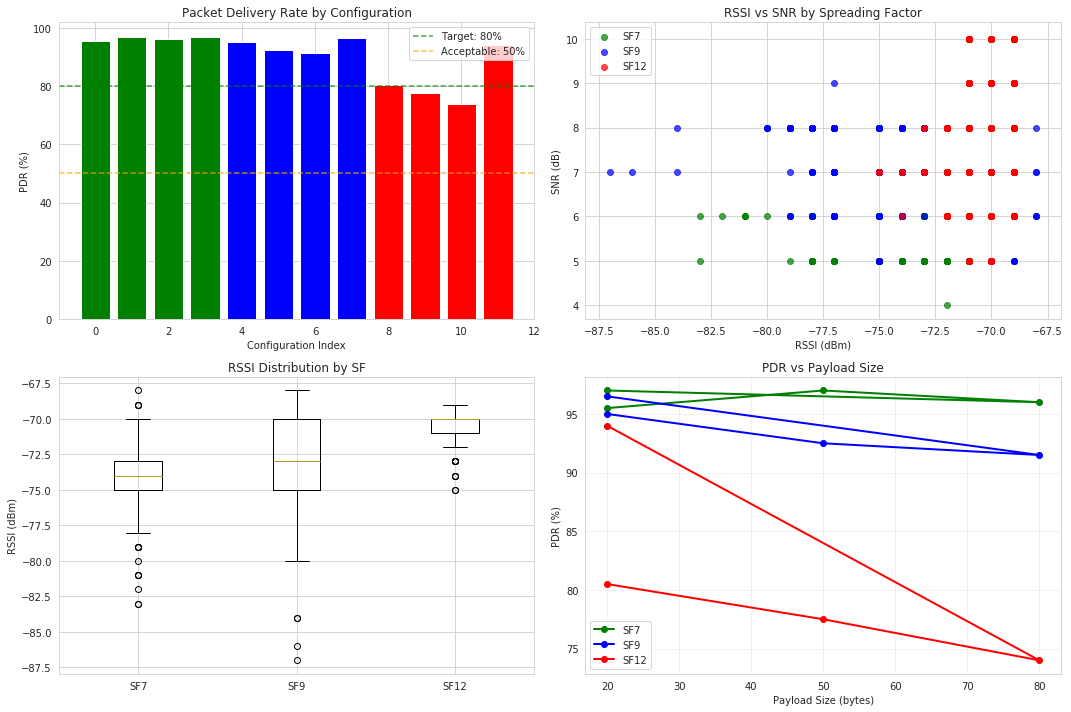

In [10]:
# PDR Analysis Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# PDR bar chart
ax1.bar(range(len(pdr_stats)), pdr_stats['pdr_percent'], 
        color=['green' if sf==7 else 'blue' if sf==9 else 'red' for sf in pdr_stats['sf']])
ax1.set_title('Packet Delivery Rate by Configuration')
ax1.set_xlabel('Configuration Index')
ax1.set_ylabel('PDR (%)')
ax1.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Target: 80%')
ax1.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='Acceptable: 50%')
ax1.legend()

# RSSI vs SNR scatter
colors = {7: 'green', 9: 'blue', 12: 'red'}
for sf in df['sf'].unique():
    sf_data = df[df['sf'] == sf]
    ax2.scatter(sf_data['rssi'], sf_data['snr'], c=colors[sf], 
               label=f'SF{sf}', alpha=0.7)
ax2.set_xlabel('RSSI (dBm)')
ax2.set_ylabel('SNR (dB)')
ax2.set_title('RSSI vs SNR by Spreading Factor')
ax2.legend()

# RSSI distribution
sf_values = sorted(df['sf'].unique())
rssi_data = [df[df['sf'] == sf]['rssi'].values for sf in sf_values]
ax3.boxplot(rssi_data, labels=[f'SF{sf}' for sf in sf_values])
ax3.set_title('RSSI Distribution by SF')
ax3.set_ylabel('RSSI (dBm)')

# PDR vs payload size
for sf in sf_values:
    sf_stats = pdr_stats[pdr_stats['sf'] == sf]
    ax4.plot(sf_stats['len'], sf_stats['pdr_percent'], 
            marker='o', linewidth=2, label=f'SF{sf}', color=colors[sf])
ax4.set_xlabel('Payload Size (bytes)')
ax4.set_ylabel('PDR (%)')
ax4.set_title('PDR vs Payload Size')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 1 - PDR Bar Chart

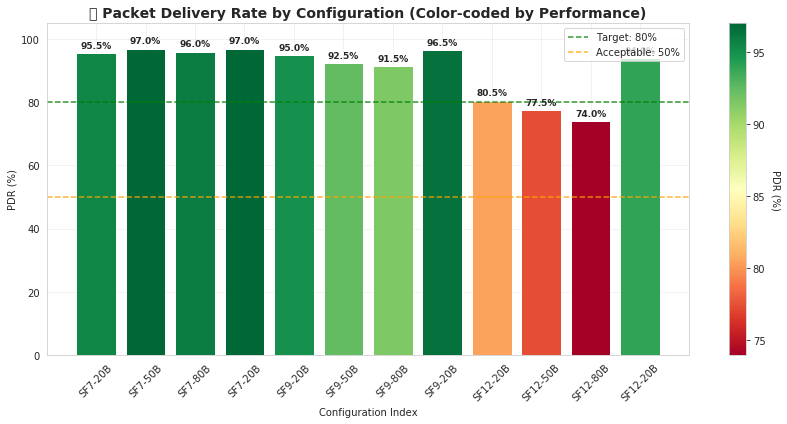

Best PDR: 97.0%
Worst PDR: 74.0%
Average PDR: 90.6%

Trying different colormaps...


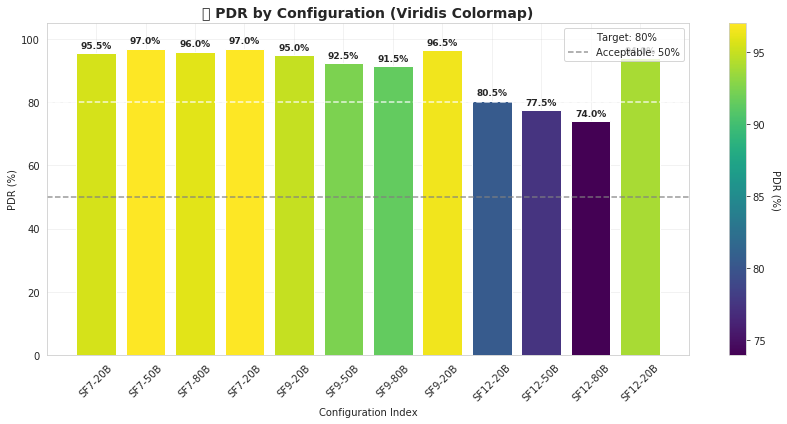

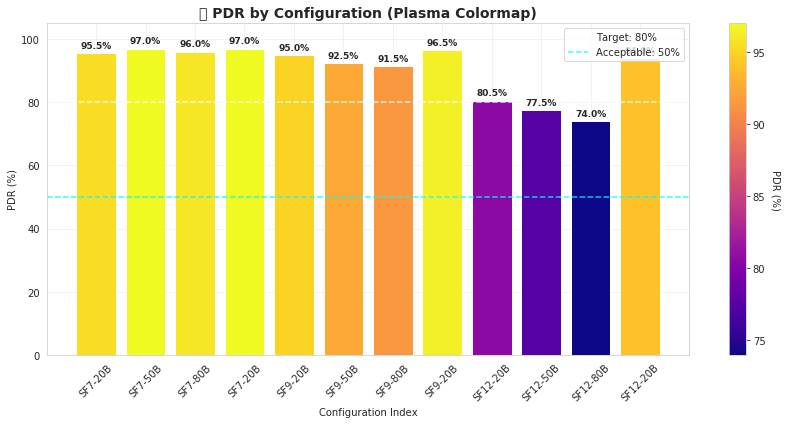

In [11]:
# Packet Delivery Rate with Gradient Colors
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Create color gradient based on PDR percentage
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Convert pandas Series to numpy array to avoid errors
pdr_values = pdr_stats['pdr_percent'].values

# Normalize PDR values for color mapping
norm = mcolors.Normalize(vmin=pdr_values.min(), vmax=pdr_values.max())
cmap = cm.RdYlGn  # Red-Yellow-Green colormap (red=bad, green=good)

# Create bars with gradient colors
bars = ax.bar(range(len(pdr_stats)), pdr_values, color=cmap(norm(pdr_values)))

ax.set_title('📊 Packet Delivery Rate by Configuration (Color-coded by Performance)', fontsize=14, fontweight='bold')
ax.set_xlabel('Configuration Index')
ax.set_ylabel('PDR (%)')
ax.set_xticks(range(len(pdr_stats)))
ax.set_xticklabels([f"SF{row['sf']}-{row['len']}B" for _, row in pdr_stats.iterrows()], rotation=45)

# Add reference lines
ax.axhline(y=80, color='green', linestyle='--', alpha=0.8, label='Target: 80%')
ax.axhline(y=50, color='orange', linestyle='--', alpha=0.8, label='Acceptable: 50%')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('PDR (%)', rotation=270, labelpad=15)

ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)  # Give some space above 100%
plt.tight_layout()
plt.show()

print(f"Best PDR: {pdr_stats['pdr_percent'].max():.1f}%")
print(f"Worst PDR: {pdr_stats['pdr_percent'].min():.1f}%")
print(f"Average PDR: {pdr_stats['pdr_percent'].mean():.1f}%")

# Alternative version with different colormap options
print("\nTrying different colormaps...")

# Version with Viridis colormap (purple to yellow)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

cmap_viridis = cm.viridis
bars = ax.bar(range(len(pdr_stats)), pdr_values, color=cmap_viridis(norm(pdr_values)))

ax.set_title('📊 PDR by Configuration (Viridis Colormap)', fontsize=14, fontweight='bold')
ax.set_xlabel('Configuration Index')
ax.set_ylabel('PDR (%)')
ax.set_xticks(range(len(pdr_stats)))
ax.set_xticklabels([f"SF{row['sf']}-{row['len']}B" for _, row in pdr_stats.iterrows()], rotation=45)

ax.axhline(y=80, color='white', linestyle='--', alpha=0.8, label='Target: 80%')
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.8, label='Acceptable: 50%')

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

sm_viridis = cm.ScalarMappable(cmap=cmap_viridis, norm=norm)
sm_viridis.set_array([])
cbar = plt.colorbar(sm_viridis, ax=ax)
cbar.set_label('PDR (%)', rotation=270, labelpad=15)

ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)
plt.tight_layout()
plt.show()

# Version with Plasma colormap (purple to pink to yellow)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

cmap_plasma = cm.plasma
bars = ax.bar(range(len(pdr_stats)), pdr_values, color=cmap_plasma(norm(pdr_values)))

ax.set_title('📊 PDR by Configuration (Plasma Colormap)', fontsize=14, fontweight='bold')
ax.set_xlabel('Configuration Index')
ax.set_ylabel('PDR (%)')
ax.set_xticks(range(len(pdr_stats)))
ax.set_xticklabels([f"SF{row['sf']}-{row['len']}B" for _, row in pdr_stats.iterrows()], rotation=45)

ax.axhline(y=80, color='white', linestyle='--', alpha=0.8, label='Target: 80%')
ax.axhline(y=50, color='cyan', linestyle='--', alpha=0.8, label='Acceptable: 50%')

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

sm_plasma = cm.ScalarMappable(cmap=cmap_plasma, norm=norm)
sm_plasma.set_array([])
cbar = plt.colorbar(sm_plasma, ax=ax)
cbar.set_label('PDR (%)', rotation=270, labelpad=15)

ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)
plt.tight_layout()
plt.show()

# Packet Loss by configuration

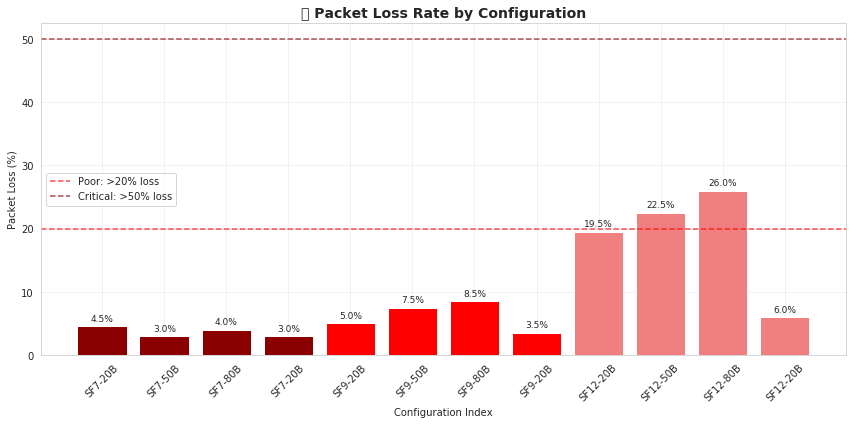

Best (Lowest) Packet Loss: 3.0%
Worst (Highest) Packet Loss: 26.0%

Creating gradient color version...


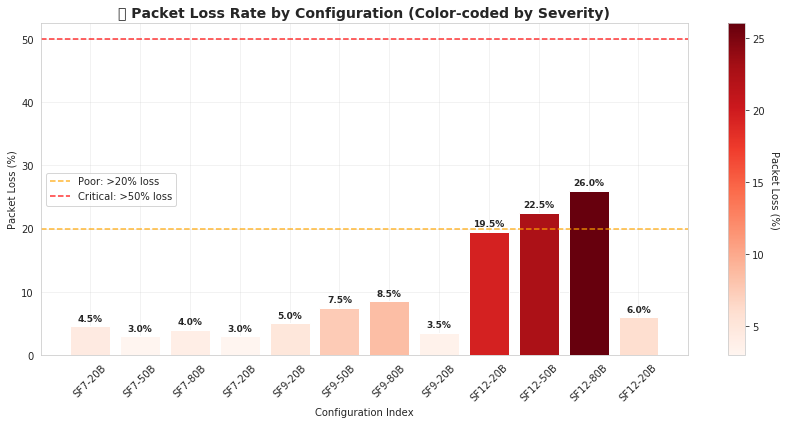

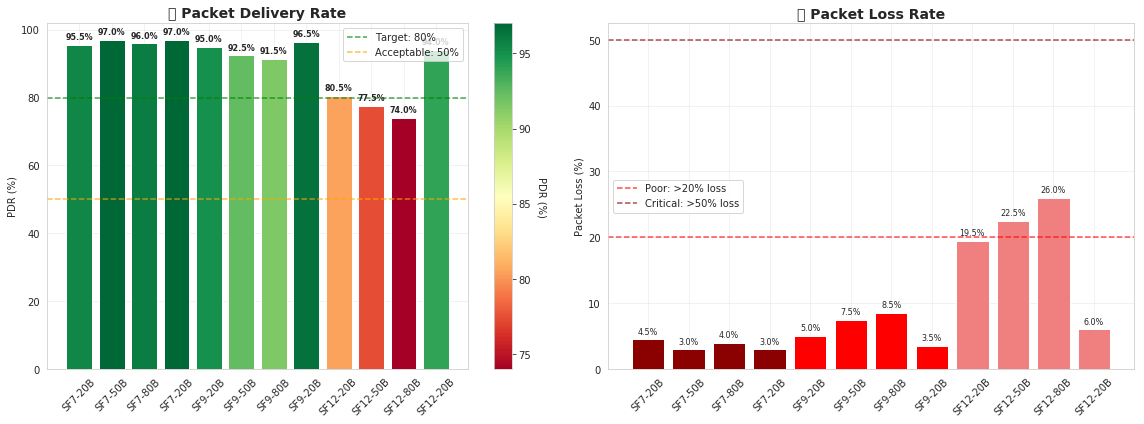


📈 Performance Summary:
Best Configuration (Highest PDR): 7_BW125_50B - 97.0% PDR
Worst Configuration (Lowest PDR): 12_BW125_80B - 74.0% PDR
Average PDR across all configs: 90.6%
Average Packet Loss across all configs: 9.4%


In [12]:
# Calculate packet loss rate (inverse of PDR)
pdr_stats['packet_loss_percent'] = 100 - pdr_stats['pdr_percent']

# Plot 1: Packet Loss Rate Bar Chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Different color scheme for packet loss (red spectrum for bad performance)
colors = ['darkred' if sf==7 else 'red' if sf==9 else 'lightcoral' for sf in pdr_stats['sf']]

bars = ax.bar(range(len(pdr_stats)), pdr_stats['packet_loss_percent'], color=colors)

ax.set_title('📉 Packet Loss Rate by Configuration', fontsize=14, fontweight='bold')
ax.set_xlabel('Configuration Index')
ax.set_ylabel('Packet Loss (%)')
ax.set_xticks(range(len(pdr_stats)))
ax.set_xticklabels([f"SF{row['sf']}-{row['len']}B" for _, row in pdr_stats.iterrows()], rotation=45)

# Add reference lines for packet loss (inverted thresholds)
ax.axhline(y=20, color='red', linestyle='--', alpha=0.7, label='Poor: >20% loss')
ax.axhline(y=50, color='darkred', linestyle='--', alpha=0.7, label='Critical: >50% loss')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9)

ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Best (Lowest) Packet Loss: {pdr_stats['packet_loss_percent'].min():.1f}%")
print(f"Worst (Highest) Packet Loss: {pdr_stats['packet_loss_percent'].max():.1f}%")

# Alternative version with gradient colors based on loss severity
print("\nCreating gradient color version...")

# Plot 2: Packet Loss with Gradient Colors
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Create color gradient based on packet loss percentage
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Convert pandas Series to numpy array to avoid the error
loss_values = pdr_stats['packet_loss_percent'].values

# Normalize packet loss values for color mapping
norm = mcolors.Normalize(vmin=loss_values.min(), vmax=loss_values.max())
cmap = cm.Reds  # Red colormap for losses

# Create bars with gradient colors
bars = ax.bar(range(len(pdr_stats)), loss_values, color=cmap(norm(loss_values)))

ax.set_title('📉 Packet Loss Rate by Configuration (Color-coded by Severity)', fontsize=14, fontweight='bold')
ax.set_xlabel('Configuration Index')
ax.set_ylabel('Packet Loss (%)')
ax.set_xticks(range(len(pdr_stats)))
ax.set_xticklabels([f"SF{row['sf']}-{row['len']}B" for _, row in pdr_stats.iterrows()], rotation=45)

# Add reference lines
ax.axhline(y=20, color='orange', linestyle='--', alpha=0.8, label='Poor: >20% loss')
ax.axhline(y=50, color='red', linestyle='--', alpha=0.8, label='Critical: >50% loss')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Packet Loss (%)', rotation=270, labelpad=15)

ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Side-by-side comparison of PDR and Packet Loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Convert to numpy array and create colormap
pdr_values = pdr_stats['pdr_percent'].values
norm = mcolors.Normalize(vmin=pdr_values.min(), vmax=pdr_values.max())
cmap = cm.RdYlGn  # Red-Yellow-Green colormap

# Create gradient bars
bars1 = ax1.bar(range(len(pdr_stats)), pdr_values, color=cmap(norm(pdr_values)))

ax1.set_title('📊 Packet Delivery Rate', fontsize=14, fontweight='bold')
ax1.set_ylabel('PDR (%)')
ax1.set_xticks(range(len(pdr_stats)))
ax1.set_xticklabels([f"SF{row['sf']}-{row['len']}B" for _, row in pdr_stats.iterrows()], rotation=45)
ax1.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Target: 80%')
ax1.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='Acceptable: 50%')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add colorbar to the subplot
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('PDR (%)', rotation=270, labelpad=15)

# Add PDR value labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%',
            ha='center', va='bottom', fontsize=8, fontweight='bold')

# Packet Loss subplot
colors_loss = ['darkred' if sf==7 else 'red' if sf==9 else 'lightcoral' for sf in pdr_stats['sf']]
bars2 = ax2.bar(range(len(pdr_stats)), pdr_stats['packet_loss_percent'], color=colors_loss)
ax2.set_title('📉 Packet Loss Rate', fontsize=14, fontweight='bold')
ax2.set_ylabel('Packet Loss (%)')
ax2.set_xticks(range(len(pdr_stats)))
ax2.set_xticklabels([f"SF{row['sf']}-{row['len']}B" for _, row in pdr_stats.iterrows()], rotation=45)
ax2.axhline(y=20, color='red', linestyle='--', alpha=0.7, label='Poor: >20% loss')
ax2.axhline(y=50, color='darkred', linestyle='--', alpha=0.7, label='Critical: >50% loss')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Add loss value labels
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{height:.1f}%',
            ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📈 Performance Summary:")
print(f"Best Configuration (Highest PDR): {pdr_stats.loc[pdr_stats['pdr_percent'].idxmax(), 'config_name']} - {pdr_stats['pdr_percent'].max():.1f}% PDR")
print(f"Worst Configuration (Lowest PDR): {pdr_stats.loc[pdr_stats['pdr_percent'].idxmin(), 'config_name']} - {pdr_stats['pdr_percent'].min():.1f}% PDR")
print(f"Average PDR across all configs: {pdr_stats['pdr_percent'].mean():.1f}%")
print(f"Average Packet Loss across all configs: {pdr_stats['packet_loss_percent'].mean():.1f}%")

# RSSI vs SNR Scatter Plot

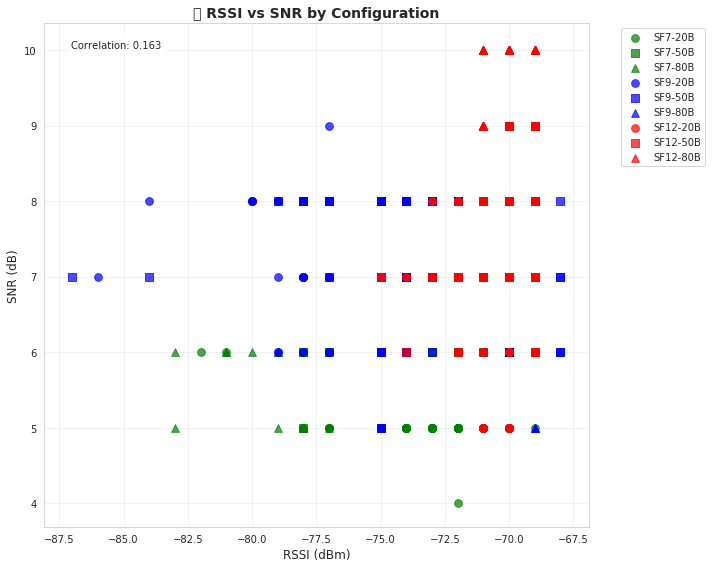

RSSI range: -87.0 to -68.0 dBm
SNR range: 4.0 to 10.0 dB


In [13]:
# Plot 2: RSSI vs SNR Scatter Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

colors = {7: 'green', 9: 'blue', 12: 'red'}
markers = {20: 'o', 50: 's', 80: '^'}  # Different markers for payload sizes

for sf in sorted(df['sf'].unique()):
    for payload in sorted(df['len'].unique()):
        subset = df[(df['sf'] == sf) & (df['len'] == payload)]
        if len(subset) > 0:
            ax.scatter(subset['rssi'], subset['snr'], 
                      c=colors[sf], marker=markers.get(payload, 'o'),
                      label=f'SF{sf}-{payload}B', alpha=0.7, s=60)

ax.set_xlabel('RSSI (dBm)', fontsize=12)
ax.set_ylabel('SNR (dB)', fontsize=12)
ax.set_title('📡 RSSI vs SNR by Configuration', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add correlation info
correlation = df['rssi'].corr(df['snr'])
ax.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
        transform=ax.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white"))

plt.tight_layout()
plt.show()

print(f"RSSI range: {df['rssi'].min():.1f} to {df['rssi'].max():.1f} dBm")
print(f"SNR range: {df['snr'].min():.1f} to {df['snr'].max():.1f} dB")

# Signal Quality Box Plots

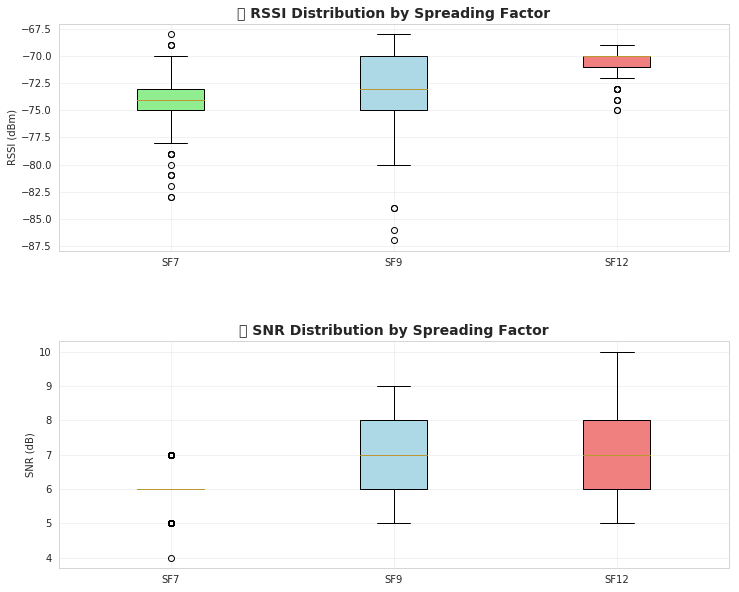

SF7: RSSI=-73.9±2.1dBm, SNR=5.9±0.6dB
SF9: RSSI=-73.0±3.1dBm, SNR=7.2±0.9dB
SF12: RSSI=-70.4±1.0dBm, SNR=7.4±1.4dB


In [14]:
# Plot 3: Signal Quality Distribution
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# RSSI distribution by SF
sf_values = sorted(df['sf'].unique())
rssi_data = [df[df['sf'] == sf]['rssi'].values for sf in sf_values]
box1 = ax1.boxplot(rssi_data, labels=[f'SF{sf}' for sf in sf_values], patch_artist=True)

colors = ['lightgreen', 'lightblue', 'lightcoral']
for patch, color in zip(box1['boxes'], colors):
    patch.set_facecolor(color)

ax1.set_title('📶 RSSI Distribution by Spreading Factor', fontsize=14, fontweight='bold')
ax1.set_ylabel('RSSI (dBm)')
ax1.grid(True, alpha=0.3)

# SNR distribution by SF
snr_data = [df[df['sf'] == sf]['snr'].values for sf in sf_values]
box2 = ax2.boxplot(snr_data, labels=[f'SF{sf}' for sf in sf_values], patch_artist=True)

for patch, color in zip(box2['boxes'], colors):
    patch.set_facecolor(color)

ax2.set_title('📊 SNR Distribution by Spreading Factor', fontsize=14, fontweight='bold')
ax2.set_ylabel('SNR (dB)')
ax2.grid(True, alpha=0.3)

#plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

# Print statistics
for sf in sf_values:
    sf_data = df[df['sf'] == sf]
    print(f"SF{sf}: RSSI={sf_data['rssi'].mean():.1f}±{sf_data['rssi'].std():.1f}dBm, "
          f"SNR={sf_data['snr'].mean():.1f}±{sf_data['snr'].std():.1f}dB")

# PDR vs Payload Size

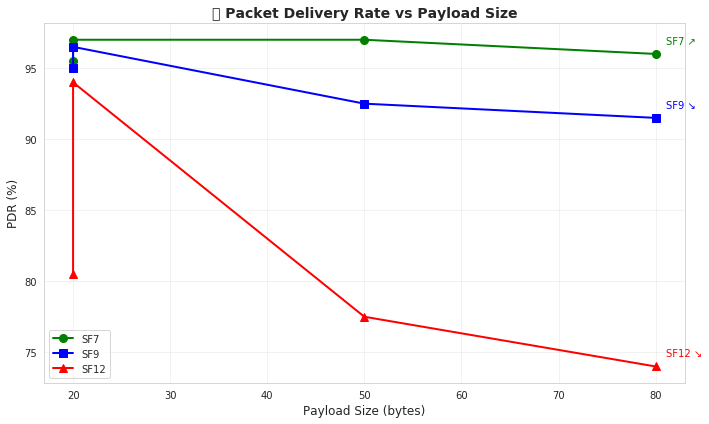

📈 Payload Size Impact Analysis:
SF7: PDR range 95.5% - 97.0%
SF9: PDR range 91.5% - 96.5%
SF12: PDR range 74.0% - 94.0%


In [15]:
# Plot 4: PDR vs Payload Size Analysis
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

colors = {7: 'green', 9: 'blue', 12: 'red'}
markers = ['o', 's', '^']

for i, sf in enumerate(sorted(pdr_stats['sf'].unique())):
    sf_data = pdr_stats[pdr_stats['sf'] == sf].sort_values('len')
    ax.plot(sf_data['len'], sf_data['pdr_percent'], 
            color=colors[sf], marker=markers[i], linewidth=2, markersize=8,
            label=f'SF{sf}')

ax.set_xlabel('Payload Size (bytes)', fontsize=12)
ax.set_ylabel('PDR (%)', fontsize=12)
ax.set_title('📦 Packet Delivery Rate vs Payload Size', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Add trend annotations
for sf in sorted(pdr_stats['sf'].unique()):
    sf_data = pdr_stats[pdr_stats['sf'] == sf].sort_values('len')
    if len(sf_data) > 1:
        trend = "↗" if sf_data['pdr_percent'].iloc[-1] > sf_data['pdr_percent'].iloc[0] else "↘"
        ax.annotate(f'SF{sf} {trend}', 
                   xy=(sf_data['len'].iloc[-1], sf_data['pdr_percent'].iloc[-1]),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=10, color=colors[sf])

plt.tight_layout()
plt.show()

print("📈 Payload Size Impact Analysis:")
for sf in sorted(pdr_stats['sf'].unique()):
    sf_data = pdr_stats[pdr_stats['sf'] == sf]
    print(f"SF{sf}: PDR range {sf_data['pdr_percent'].min():.1f}% - {sf_data['pdr_percent'].max():.1f}%")

# Cell: Boxplot PDR vs SF

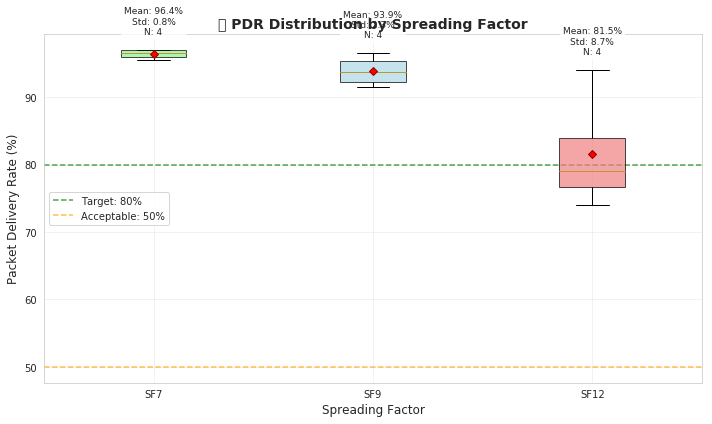

📈 PDR Statistics by Spreading Factor:
----------------------------------------
SF7: Mean=96.4%, Median=96.5%, Min=95.5%, Max=97.0%, Std=0.8%
SF9: Mean=93.9%, Median=93.8%, Min=91.5%, Max=96.5%, Std=2.3%
SF12: Mean=81.5%, Median=79.0%, Min=74.0%, Max=94.0%, Std=8.7%

🔬 ANOVA Test:
F-statistic: 9.251, p-value: 0.007
✅ Significant difference between SF groups (p < 0.05)


In [16]:
# Boxplot: PDR vs Spreading Factor
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Prepare data for boxplot - group PDR values by SF
sf_values = sorted(pdr_stats['sf'].unique())
pdr_by_sf = []

for sf in sf_values:
    sf_data = pdr_stats[pdr_stats['sf'] == sf]['pdr_percent'].values
    pdr_by_sf.append(sf_data)

# Create boxplot
box_plot = ax.boxplot(pdr_by_sf, labels=[f'SF{sf}' for sf in sf_values], 
                      patch_artist=True, showmeans=True)

# Color the boxes
colors = ['lightgreen', 'lightblue', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors[:len(sf_values)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Customize means markers
for mean in box_plot['means']:
    mean.set_marker('D')  # Diamond shape
    mean.set_markerfacecolor('red')
    mean.set_markeredgecolor('darkred')
    mean.set_markersize(6)

ax.set_title('📊 PDR Distribution by Spreading Factor', fontsize=14, fontweight='bold')
ax.set_xlabel('Spreading Factor', fontsize=12)
ax.set_ylabel('Packet Delivery Rate (%)', fontsize=12)

# Add reference lines
ax.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Target: 80%')
ax.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='Acceptable: 50%')

# Add grid
ax.grid(True, alpha=0.3)
ax.legend()

# Add statistics annotations
for i, sf in enumerate(sf_values):
    sf_data = pdr_stats[pdr_stats['sf'] == sf]['pdr_percent']
    mean_val = sf_data.mean()
    std_val = sf_data.std()
    
    # Add text box with statistics
    stats_text = f'Mean: {mean_val:.1f}%\nStd: {std_val:.1f}%\nN: {len(sf_data)}'
    ax.text(i+1, max(sf_data) + 2, stats_text, 
            ha='center', va='bottom', fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary statistics
print("📈 PDR Statistics by Spreading Factor:")
print("-" * 40)
for sf in sf_values:
    sf_data = pdr_stats[pdr_stats['sf'] == sf]['pdr_percent']
    print(f"SF{sf}: Mean={sf_data.mean():.1f}%, Median={sf_data.median():.1f}%, "
          f"Min={sf_data.min():.1f}%, Max={sf_data.max():.1f}%, Std={sf_data.std():.1f}%")

# Statistical significance test (if scipy available)
try:
    from scipy import stats
    if len(sf_values) >= 2:
        pdr_groups = [pdr_stats[pdr_stats['sf'] == sf]['pdr_percent'].values for sf in sf_values]
        f_stat, p_value = stats.f_oneway(*pdr_groups)
        print(f"\n🔬 ANOVA Test:")
        print(f"F-statistic: {f_stat:.3f}, p-value: {p_value:.3f}")
        if p_value < 0.05:
            print("✅ Significant difference between SF groups (p < 0.05)")
        else:
            print("❌ No significant difference between SF groups (p ≥ 0.05)")
except ImportError:
    print("\n📊 Install scipy for statistical significance testing")

# RSSI vs SNR Scatter Plot

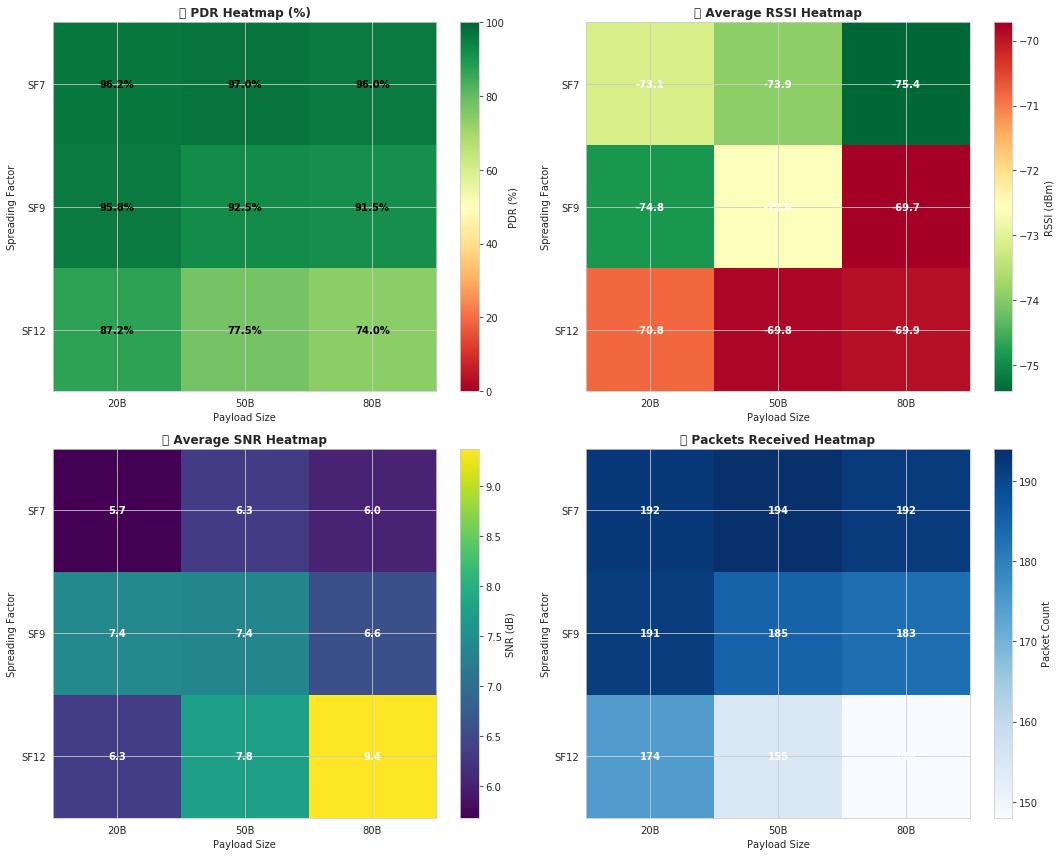

In [17]:
# Plot 5: Performance Heatmaps
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# PDR Heatmap
pdr_pivot = pdr_stats.pivot_table(values='pdr_percent', index='sf', columns='len', fill_value=0)
im1 = ax1.imshow(pdr_pivot.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
ax1.set_title('✅ PDR Heatmap (%)', fontsize=12, fontweight='bold')
ax1.set_xticks(range(len(pdr_pivot.columns)))
ax1.set_xticklabels([f'{col}B' for col in pdr_pivot.columns])
ax1.set_yticks(range(len(pdr_pivot.index)))
ax1.set_yticklabels([f'SF{idx}' for idx in pdr_pivot.index])
ax1.set_xlabel('Payload Size')
ax1.set_ylabel('Spreading Factor')

# Add text annotations
for i in range(len(pdr_pivot.index)):
    for j in range(len(pdr_pivot.columns)):
        text = ax1.text(j, i, f'{pdr_pivot.values[i, j]:.1f}%',
                       ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im1, ax=ax1, label='PDR (%)')

# RSSI Heatmap
rssi_pivot = pdr_stats.pivot_table(values='rssi_mean', index='sf', columns='len', fill_value=0)
im2 = ax2.imshow(rssi_pivot.values, cmap='RdYlGn_r', aspect='auto')
ax2.set_title('📡 Average RSSI Heatmap', fontsize=12, fontweight='bold')
ax2.set_xticks(range(len(rssi_pivot.columns)))
ax2.set_xticklabels([f'{col}B' for col in rssi_pivot.columns])
ax2.set_yticks(range(len(rssi_pivot.index)))
ax2.set_yticklabels([f'SF{idx}' for idx in rssi_pivot.index])
ax2.set_xlabel('Payload Size')
ax2.set_ylabel('Spreading Factor')

for i in range(len(rssi_pivot.index)):
    for j in range(len(rssi_pivot.columns)):
        text = ax2.text(j, i, f'{rssi_pivot.values[i, j]:.1f}',
                       ha="center", va="center", color="white", fontweight='bold')

plt.colorbar(im2, ax=ax2, label='RSSI (dBm)')

# SNR Heatmap
snr_pivot = pdr_stats.pivot_table(values='snr_mean', index='sf', columns='len', fill_value=0)
im3 = ax3.imshow(snr_pivot.values, cmap='viridis', aspect='auto')
ax3.set_title('📶 Average SNR Heatmap', fontsize=12, fontweight='bold')
ax3.set_xticks(range(len(snr_pivot.columns)))
ax3.set_xticklabels([f'{col}B' for col in snr_pivot.columns])
ax3.set_yticks(range(len(snr_pivot.index)))
ax3.set_yticklabels([f'SF{idx}' for idx in snr_pivot.index])
ax3.set_xlabel('Payload Size')
ax3.set_ylabel('Spreading Factor')

for i in range(len(snr_pivot.index)):
    for j in range(len(snr_pivot.columns)):
        text = ax3.text(j, i, f'{snr_pivot.values[i, j]:.1f}',
                       ha="center", va="center", color="white", fontweight='bold')

plt.colorbar(im3, ax=ax3, label='SNR (dB)')

# Packet Count Heatmap
count_pivot = pdr_stats.pivot_table(values='packets_received', index='sf', columns='len', fill_value=0)
im4 = ax4.imshow(count_pivot.values, cmap='Blues', aspect='auto')
ax4.set_title('📊 Packets Received Heatmap', fontsize=12, fontweight='bold')
ax4.set_xticks(range(len(count_pivot.columns)))
ax4.set_xticklabels([f'{col}B' for col in count_pivot.columns])
ax4.set_yticks(range(len(count_pivot.index)))
ax4.set_yticklabels([f'SF{idx}' for idx in count_pivot.index])
ax4.set_xlabel('Payload Size')
ax4.set_ylabel('Spreading Factor')

for i in range(len(count_pivot.index)):
    for j in range(len(count_pivot.columns)):
        text = ax4.text(j, i, f'{int(count_pivot.values[i, j])}',
                       ha="center", va="center", color="white", fontweight='bold')

plt.colorbar(im4, ax=ax4, label='Packet Count')

plt.tight_layout()
plt.show()

# Plot 3: Interactive Time Series Analysis

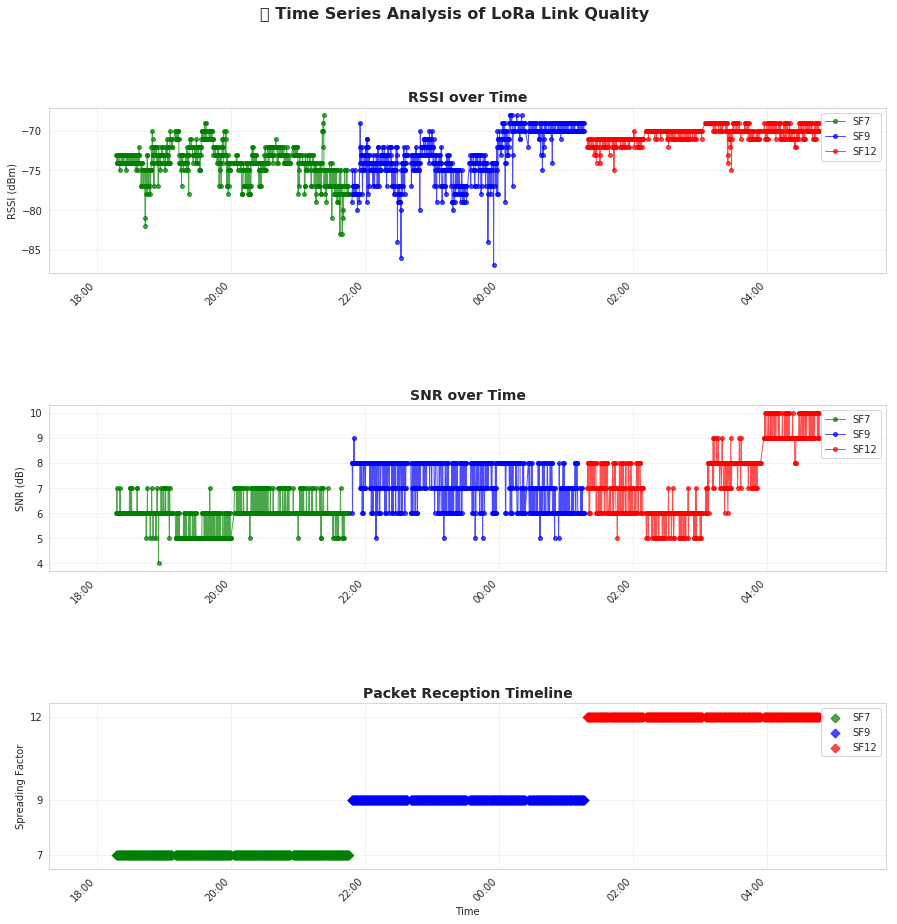

In [18]:
# ===========================
# PLOT 3: TIME SERIES ANALYSIS (Matplotlib Version)
# ===========================

# Create figure with subplots and extra spacing
fig, axes = plt.subplots(3, 1, figsize=(15, 14))  # Increased height from 12 to 14
fig.suptitle('📈 Time Series Analysis of LoRa Link Quality', fontsize=16, fontweight='bold')

# Color map for different SF values
colors = {7: 'green', 9: 'blue', 12: 'red'}

# Get the time range from your data
data_time_min = df['timestamp'].min()
data_time_max = df['timestamp'].max()

# Add 24-hour margins
time_min = data_time_min - pd.Timedelta(hours=1)
time_max = data_time_max + pd.Timedelta(hours=1)

# Plot for each SF
for sf in sorted(df['sf'].unique()):
    sf_data = df[df['sf'] == sf]
    
    # Convert timestamp to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(sf_data['timestamp']):
        sf_data = sf_data.copy()
        sf_data['timestamp'] = pd.to_datetime(sf_data['timestamp'])
    
    # RSSI time series (subplot 1)
    axes[0].plot(sf_data['timestamp'], sf_data['rssi'], 
                'o-', color=colors[sf], label=f'SF{sf}', 
                markersize=4, linewidth=1, alpha=0.7)
    
    # SNR time series (subplot 2)
    axes[1].plot(sf_data['timestamp'], sf_data['snr'], 
                'o-', color=colors[sf], label=f'SF{sf}', 
                markersize=4, linewidth=1, alpha=0.7)
    
    # Packet timeline (subplot 3) - convert to arrays to avoid type issues
    x_vals = sf_data['timestamp'].values
    y_vals = np.full(len(sf_data), sf)  # Create array of SF values
    
    axes[2].scatter(x_vals, y_vals, 
                   color=colors[sf], label=f'SF{sf}', 
                   s=40, marker='D', alpha=0.7)

# Customize subplot 1 (RSSI)
axes[0].set_title('RSSI over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('RSSI (dBm)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(time_min, time_max)  # Set consistent x-axis limits

# Customize subplot 2 (SNR)
axes[1].set_title('SNR over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('SNR (dB)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(time_min, time_max)  # Set consistent x-axis limits

# Customize subplot 3 (Packet Timeline)
axes[2].set_title('Packet Reception Timeline', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Spreading Factor')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim(time_min, time_max)  # Restrict to actual data time range

# Set y-axis limits for packet timeline to show SF values clearly
sf_values = sorted(df['sf'].unique())
axes[2].set_ylim(min(sf_values) - 0.5, max(sf_values) + 0.5)
axes[2].set_yticks(sf_values)

# Rotate x-axis labels for better readability
for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Add more space between subplots
plt.subplots_adjust(hspace=0.8)  # Increase vertical spacing

# Optional: Set x-axis to show hourly ticks for 12-hour dataset
from matplotlib.dates import DateFormatter, HourLocator
for ax in axes:
    ax.xaxis.set_major_locator(HourLocator(interval=2))  # Show every 2 hours
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # Format as HH:MM

plt.show()

# Plot 4: Link Budget Analysis

Payload Size Legend:
  7_BW125_20B: 20 bytes
  7_BW125_50B: 50 bytes
  7_BW125_80B: 80 bytes
  7_BW500_20B: 20 bytes
  9_BW125_20B: 20 bytes
  9_BW125_50B: 50 bytes
  9_BW125_80B: 80 bytes
  9_BW500_20B: 20 bytes
  12_BW125_20B: 20 bytes
  12_BW125_50B: 50 bytes
  12_BW125_80B: 80 bytes
  12_BW500_20B: 20 bytes

Creating separate plots for better visibility... 




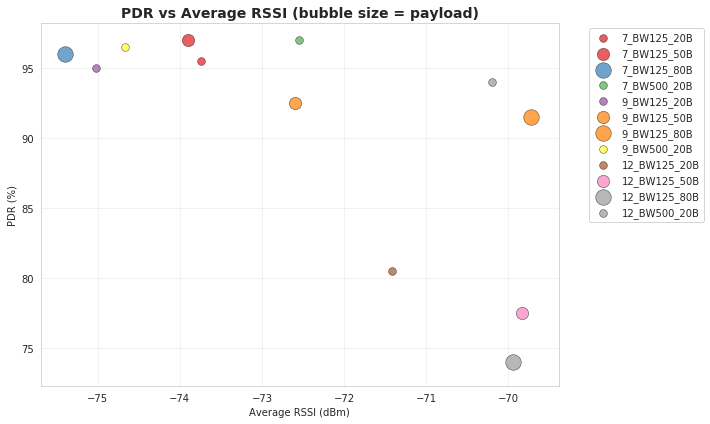

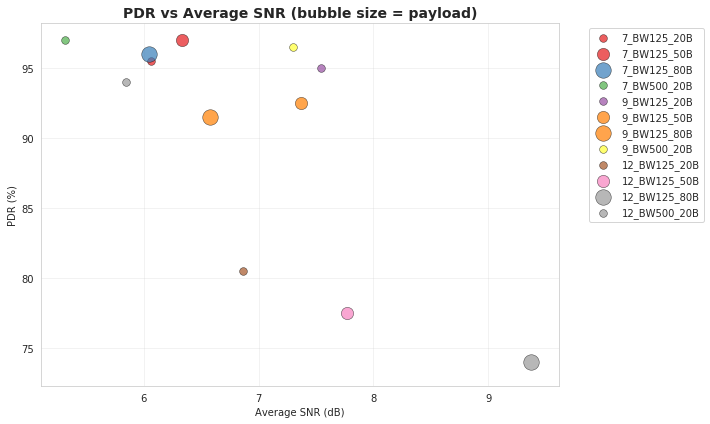

In [19]:
# ===========================
# PLOT 4: LINK BUDGET ANALYSIS (Matplotlib Version)
# ===========================

# Get unique configurations and assign colors
configs = pdr_stats['config_name'].unique()
colors = plt.cm.Set1(np.linspace(0, 1, len(configs)))
color_map = {config: colors[i] for i, config in enumerate(configs)}

"""
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Link Budget Analysis', fontsize=16, fontweight='bold')


# Plot 1: PDR vs Average RSSI
for config in configs:
    config_data = pdr_stats[pdr_stats['config_name'] == config]
    
    # Use payload size (len) for bubble size, scale it appropriately
    bubble_sizes = config_data['len'] * 3  # Scale factor for visibility
    
    ax1.scatter(config_data['rssi_mean'], config_data['pdr_percent'],
               c=[color_map[config]], s=bubble_sizes, alpha=0.7,
               label=config, edgecolors='black', linewidth=0.5)

ax1.set_title('PDR vs Average RSSI (bubble size = payload)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Average RSSI (dBm)')
ax1.set_ylabel('PDR (%)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: PDR vs Average SNR
for config in configs:
    config_data = pdr_stats[pdr_stats['config_name'] == config]
    
    # Use payload size (len) for bubble size, scale it appropriately
    bubble_sizes = config_data['len'] * 3  # Scale factor for visibility
    
    ax2.scatter(config_data['snr_mean'], config_data['pdr_percent'],
               c=[color_map[config]], s=bubble_sizes, alpha=0.7,
               label=config, edgecolors='black', linewidth=0.5)

ax2.set_title('PDR vs Average SNR (bubble size = payload)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Average SNR (dB)')
ax2.set_ylabel('PDR (%)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
"""

# Optional: Add text annotations showing payload sizes
print("Payload Size Legend:")
for config in configs:
    config_data = pdr_stats[pdr_stats['config_name'] == config]
    if len(config_data) > 0:
        payload_size = config_data['len'].iloc[0]
        print(f"  {config}: {payload_size} bytes")

# Alternative version with separate plots for cleaner legends
print("\nCreating separate plots for better visibility... \n\n")

# Separate plot for RSSI
plt.figure(figsize=(10, 6))
for config in configs:
    config_data = pdr_stats[pdr_stats['config_name'] == config]
    bubble_sizes = config_data['len'] * 3
    
    plt.scatter(config_data['rssi_mean'], config_data['pdr_percent'],
               c=[color_map[config]], s=bubble_sizes, alpha=0.7,
               label=config, edgecolors='black', linewidth=0.5)

plt.title('PDR vs Average RSSI (bubble size = payload)', fontsize=14, fontweight='bold')
plt.xlabel('Average RSSI (dBm)')
plt.ylabel('PDR (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\n" * 4) 

# Separate plot for SNR
plt.figure(figsize=(10, 6))
for config in configs:
    config_data = pdr_stats[pdr_stats['config_name'] == config]
    bubble_sizes = config_data['len'] * 3
    
    plt.scatter(config_data['snr_mean'], config_data['pdr_percent'],
               c=[color_map[config]], s=bubble_sizes, alpha=0.7,
               label=config, edgecolors='black', linewidth=0.5)

plt.title('PDR vs Average SNR (bubble size = payload)', fontsize=14, fontweight='bold')
plt.xlabel('Average SNR (dB)')
plt.ylabel('PDR (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
#plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()

# Plot 4

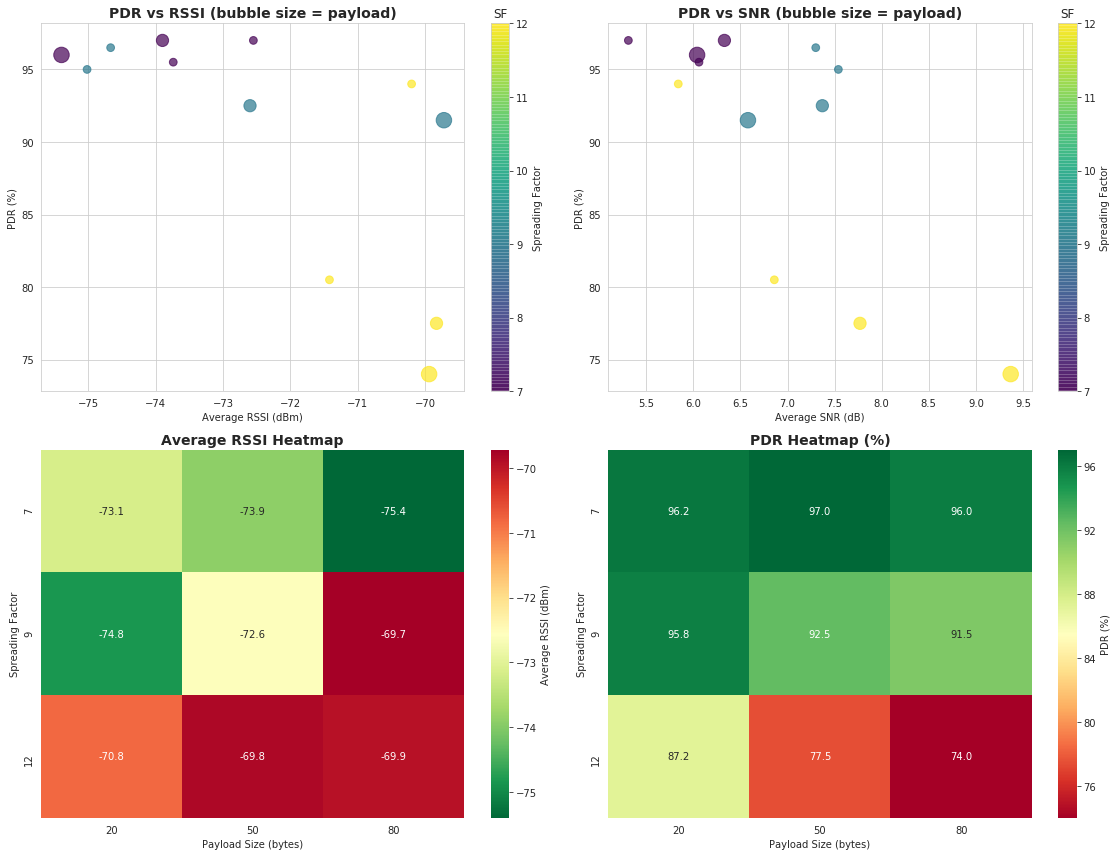

In [20]:
# ===========================
# PLOT 4: LINK BUDGET ANALYSIS
# ===========================

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# PDR vs Average RSSI
scatter1 = ax1.scatter(pdr_stats['rssi_mean'], pdr_stats['pdr_percent'],
           c=pdr_stats['sf'], cmap='viridis', s=pdr_stats['len']*3, alpha=0.7)
ax1.set_xlabel('Average RSSI (dBm)')
ax1.set_ylabel('PDR (%)')
ax1.set_title('PDR vs RSSI (bubble size = payload)', fontsize=14, fontweight='bold')
cbar1 = plt.colorbar(scatter1, ax=ax1, label='Spreading Factor') # Added colorbar label
cbar1.ax.set_title('SF') # Added colorbar title


# PDR vs Average SNR
scatter2 = ax2.scatter(pdr_stats['snr_mean'], pdr_stats['pdr_percent'],
           c=pdr_stats['sf'], cmap='viridis', s=pdr_stats['len']*3, alpha=0.7)
ax2.set_xlabel('Average SNR (dB)')
ax2.set_ylabel('PDR (%)')
ax2.set_title('PDR vs SNR (bubble size = payload)', fontsize=14, fontweight='bold')
cbar2 = plt.colorbar(scatter2, ax=ax2, label='Spreading Factor') # Added colorbar label
cbar2.ax.set_title('SF') # Added colorbar title

# Signal strength heatmap
pivot_rssi = pdr_stats.pivot_table(values='rssi_mean', index='sf', columns='len', fill_value=0)
sns.heatmap(pivot_rssi, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax3, cbar_kws={'label': 'Average RSSI (dBm)'}) # Added colorbar label
ax3.set_title('Average RSSI Heatmap', fontsize=14, fontweight='bold')
ax3.set_xlabel('Payload Size (bytes)')
ax3.set_ylabel('Spreading Factor')

# PDR heatmap
pivot_pdr = pdr_stats.pivot_table(values='pdr_percent', index='sf', columns='len', fill_value=0)
sns.heatmap(pivot_pdr, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax4, cbar_kws={'label': 'PDR (%)'}) # Added colorbar label
ax4.set_title('PDR Heatmap (%)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Payload Size (bytes)')
ax4.set_ylabel('Spreading Factor')

plt.tight_layout()
plt.show()

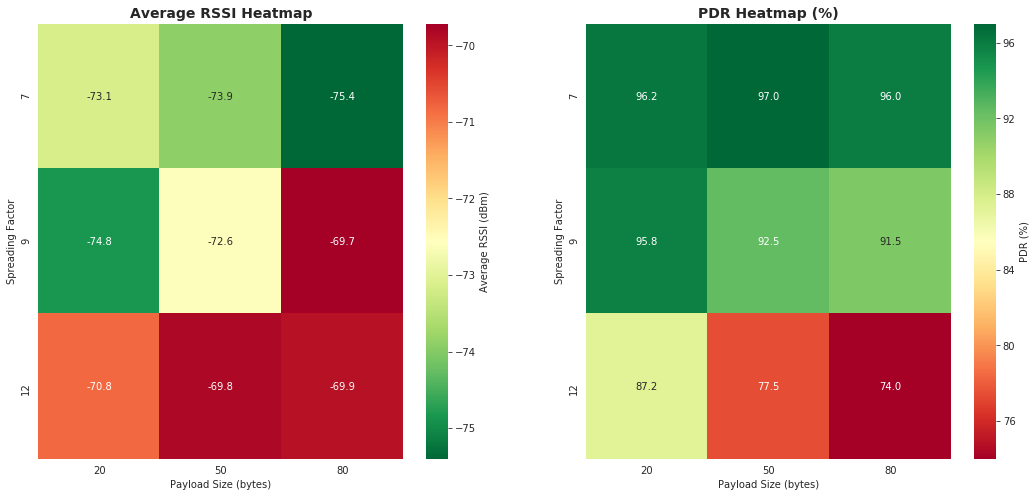

In [21]:
# ===========================
# PLOT 4 (Part 2): LINK BUDGET ANALYSIS (Heatmaps Only)
# ===========================

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(18, 8))

# Signal strength heatmap
pivot_rssi = pdr_stats.pivot_table(values='rssi_mean', index='sf', columns='len', fill_value=0)
sns.heatmap(pivot_rssi, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax3, cbar_kws={'label': 'Average RSSI (dBm)'}) # Added colorbar label
ax3.set_title('Average RSSI Heatmap', fontsize=14, fontweight='bold')
ax3.set_xlabel('Payload Size (bytes)')
ax3.set_ylabel('Spreading Factor')

# PDR heatmap
pivot_pdr = pdr_stats.pivot_table(values='pdr_percent', index='sf', columns='len', fill_value=0)
sns.heatmap(pivot_pdr, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax4, cbar_kws={'label': 'PDR (%)'}) # Added colorbar label
ax4.set_title('PDR Heatmap (%)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Payload Size (bytes)')
ax4.set_ylabel('Spreading Factor')

#plt.tight_layout()
plt.show()

# Cell 6: Summary Analysis

In [22]:
# Analysis Summary
print("🔬 ANALYSIS RESULTS")
print("=" * 50)

# Best/worst configurations
best_idx = pdr_stats['pdr_percent'].idxmax()
worst_idx = pdr_stats['pdr_percent'].idxmin()

print(f"\n🏆 Best Configuration:")
best = pdr_stats.iloc[best_idx]
print(f"   SF{best['sf']}, BW{best['bw']}, {best['len']}B payload")
print(f"   PDR: {best['pdr_percent']}%, RSSI: {best['rssi_mean']:.1f}dBm")

print(f"\n❌ Worst Configuration:")
worst = pdr_stats.iloc[worst_idx]
print(f"   SF{worst['sf']}, BW{worst['bw']}, {worst['len']}B payload")
print(f"   PDR: {worst['pdr_percent']}%, RSSI: {worst['rssi_mean']:.1f}dBm")

print(f"\n📊 Overall Statistics:")
print(f"   Average PDR: {pdr_stats['pdr_percent'].mean():.1f}%")
print(f"   RSSI range: {df['rssi'].min():.1f} to {df['rssi'].max():.1f} dBm")
print(f"   SNR range: {df['snr'].min():.1f} to {df['snr'].max():.1f} dB")

print(f"\n⏱️ Timing Recommendations:")
for sf in sorted(df['sf'].unique()):
    sf_pdr = pdr_stats[pdr_stats['sf'] == sf]['pdr_percent'].mean()
    if sf_pdr < 50:
        rec = "Increase interval to 15-20s"
    elif sf_pdr < 75:
        rec = "Increase interval to 10-12s"
    else:
        rec = "Current timing acceptable"
    print(f"   SF{sf}: Avg PDR={sf_pdr:.1f}% → {rec}")

🔬 ANALYSIS RESULTS

🏆 Best Configuration:
   SF7, BW125, 50B payload
   PDR: 97.0%, RSSI: -73.9dBm

❌ Worst Configuration:
   SF12, BW125, 80B payload
   PDR: 74.0%, RSSI: -69.9dBm

📊 Overall Statistics:
   Average PDR: 90.6%
   RSSI range: -87.0 to -68.0 dBm
   SNR range: 4.0 to 10.0 dB

⏱️ Timing Recommendations:
   SF7: Avg PDR=96.4% → Current timing acceptable
   SF9: Avg PDR=93.9% → Current timing acceptable
   SF12: Avg PDR=81.5% → Current timing acceptable


# 9. Packet Interval Analysis


⏳ Analyzing Packet Intervals with Target Interval: 15 seconds

Calculated packet intervals within each configuration.


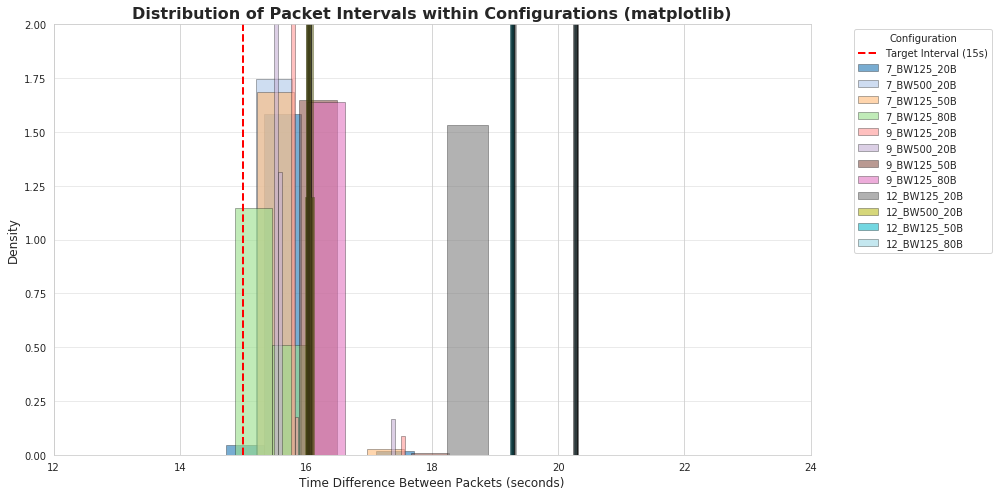

In [23]:
# ===========================
# 9. Packet Interval Analysis (Compatible with older seaborn/python)
# ===========================

df_intervals = df
# Define a constant for the target packet interval in seconds
TARGET_INTERVAL_SECONDS = 15 # Example: Set the expected interval between packets

print(f"\n⏳ Analyzing Packet Intervals with Target Interval: {TARGET_INTERVAL_SECONDS} seconds")

# Calculate the difference in timestamp for consecutive packets within each configuration
# This is crucial because interval expectations might be specific to a configuration
# We'll group by 'config' before calculating the difference
df['time_diff_seconds_within_config'] = df.groupby('config')['timestamp'].diff().dt.total_seconds()

# The first packet within each config group will have a NaN diff, fill with 0 or the first interval if known
# For this analysis, we're interested in the intervals *between* packets, so NaNs at the start are fine
df['time_diff_seconds_within_config'] = df['time_diff_seconds_within_config'].fillna(0) # Fill the very first row of each group with 0

print(f"\nCalculated packet intervals within each configuration.")

# ===========================
# OPTION 2: Using basic matplotlib (most compatible)
# ===========================

plt.figure(figsize=(14, 7))

# Get unique configurations and create a color palette
configs = df_intervals['config'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(configs)))

# Plot histogram for each configuration
for i, config in enumerate(configs):
    config_data = df_intervals[df_intervals['config'] == config]['time_diff_seconds_within_config']
    # Remove zeros and outliers for better visualization
    config_data = config_data[(config_data > 0) & (config_data < 50)]

    if len(config_data) > 0:
        plt.hist(config_data, bins=30, alpha=0.6, label=config, 
                color=colors[i], density=True, edgecolor='black', linewidth=0.5)

plt.axvline(TARGET_INTERVAL_SECONDS, color='red', linestyle='dashed', 
            linewidth=2, label=f'Target Interval ({TARGET_INTERVAL_SECONDS}s)')

plt.title('Distribution of Packet Intervals within Configurations (matplotlib)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Time Difference Between Packets (seconds)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.5)
plt.xlim(12, 24) # Restrict x-axis to 12s-24s
plt.ylim(0, 2)
plt.tight_layout()
plt.show()


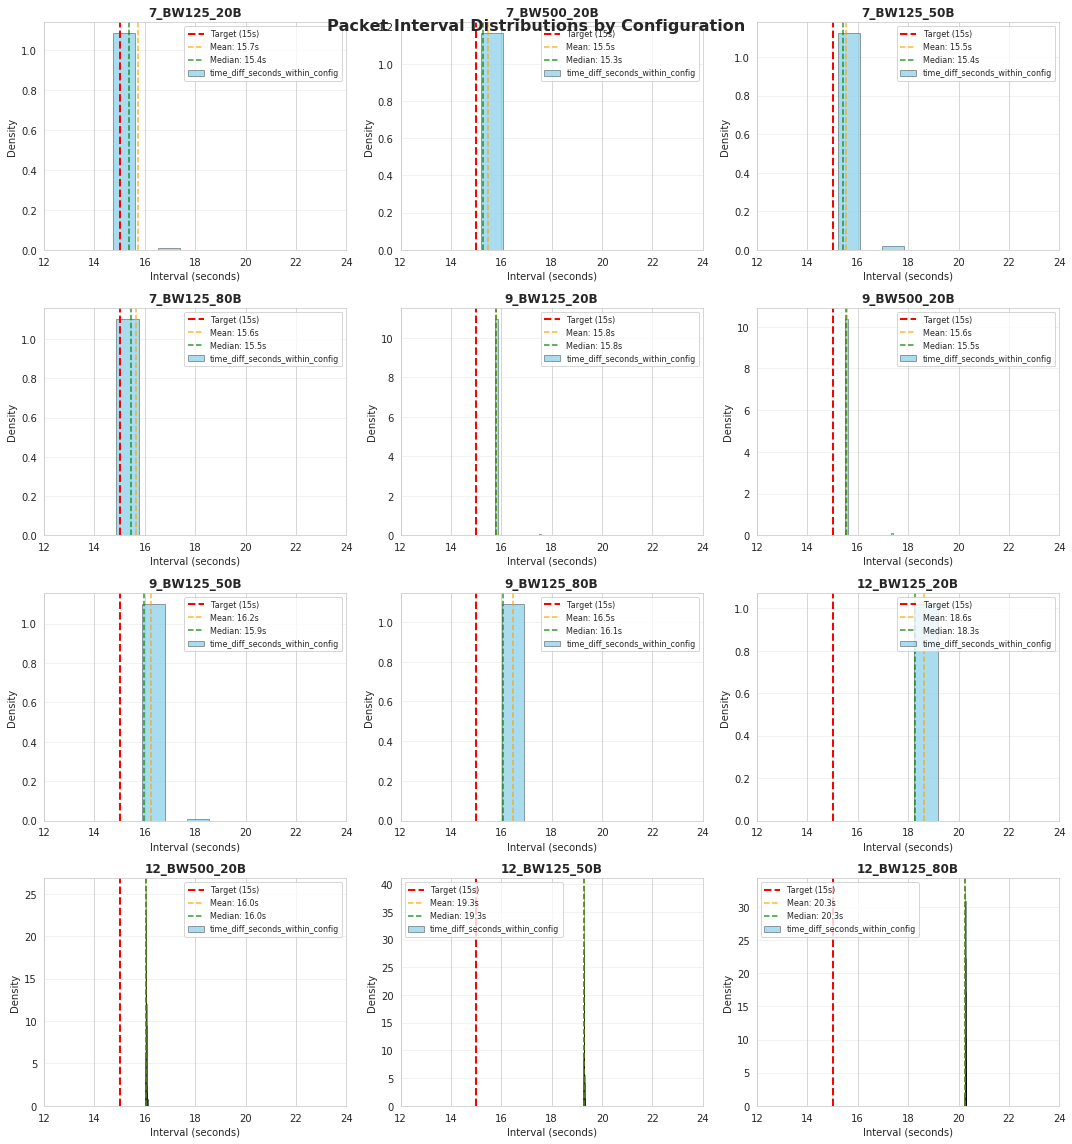


📈 Interval Analysis per Configuration:

Interval Statistics:
               mean  median   std  min    max  count  target  dev_mean  dev_median
config                                                                            
12_BW125_20B  18.53   18.28  2.98  0.0  37.45    161      15      3.53        3.28
12_BW125_50B  19.15   19.28  1.55  0.0  19.33    155      15      4.15        4.28
12_BW125_80B  20.14   20.27  1.67  0.0  20.31    148      15      5.14        5.27
12_BW500_20B  15.96   16.05  1.17  0.0  16.12    188      15      0.96        1.05
7_BW125_20B   15.65   15.36  2.73  0.0  32.59    191      15      0.65        0.36
7_BW125_50B   15.45   15.41  1.68  0.0  32.67    194      15      0.45        0.41
7_BW125_80B   15.56   15.46  2.09  0.0  32.78    192      15      0.56        0.46
7_BW500_20B   15.38   15.28  2.02  0.0  32.21    194      15      0.38        0.28
9_BW125_20B   15.72   15.79  1.15  0.0  17.57    190      15      0.72        0.79
9_BW125_50B   16.16   15.

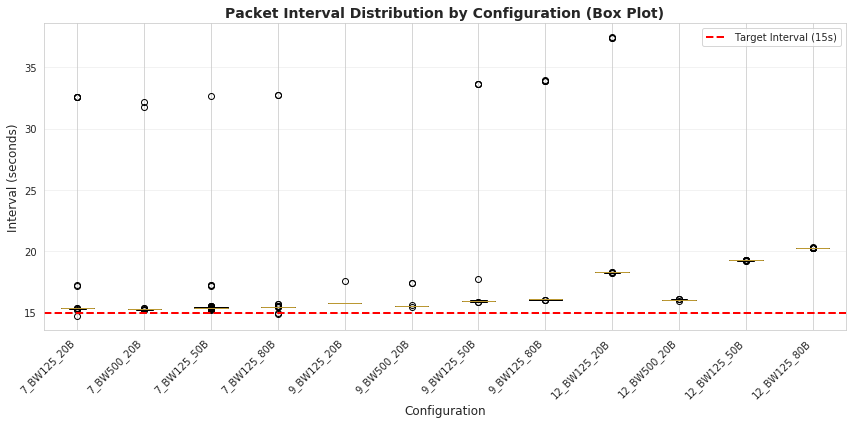


🧠 Interpretation of Packet Interval Analysis:

- Average/Median Interval (mean, median columns): Compare these to the TARGET_INTERVAL_SECONDS (15s). Values significantly higher might indicate delays, network congestion, or issues with the transmitting node's timing. Values lower might suggest bursts or inaccurate timing.

- Standard Deviation (std column): A high standard deviation indicates significant variability in packet arrival times. This can impact applications sensitive to consistent timing, like real-time monitoring.

- Minimum/Maximum Interval (min, max columns): Extreme values can highlight anomalies. Very small 'min' values might be duplicates or rapid bursts. Very large 'max' values show significant gaps in reception.

- Deviation from Target: Positive values mean the average/median interval is longer than expected. Negative values mean it's shorter.

- Compare Configurations: Look for how different configurations (SF, BW, Payload) affect the interval statistics. Do highe

In [24]:
# ===========================
# 9. Packet Interval Analysis (Compatible with older seaborn/python)
# ===========================

# ===========================
# OPTION 3: Separate subplots for each configuration (cleaner for many configs)
# ===========================
configs = df_intervals['config'].unique()
n_configs = len(configs)

# Calculate subplot grid
n_cols = 3
n_rows = (n_configs + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

for i, config in enumerate(configs):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    
    config_data = df_intervals[df_intervals['config'] == config]['time_diff_seconds_within_config']
    # Remove zeros and outliers for better visualization
    config_data = config_data[(config_data > 0) & (config_data < 50)]
    
    if len(config_data) > 0:
        ax.hist(config_data, bins=20, alpha=0.7, color='skyblue', 
                edgecolor='black', linewidth=0.5, density=True)
        ax.axvline(TARGET_INTERVAL_SECONDS, color='red', linestyle='dashed', 
                   linewidth=2, label=f'Target ({TARGET_INTERVAL_SECONDS}s)')
        
        # Add statistics text
        mean_val = config_data.mean()
        median_val = config_data.median()
        ax.axvline(mean_val, color='orange', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.1f}s')
        ax.axvline(median_val, color='green', linestyle='--', alpha=0.8, label=f'Median: {median_val:.1f}s')
    
    ax.set_title(f'{config}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Interval (seconds)', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xlim(12, 24)

# Hide empty subplots
for i in range(n_configs, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].set_visible(False)

plt.suptitle('Packet Interval Distributions by Configuration', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📈 Interval Analysis per Configuration:")
interval_stats = df_intervals.groupby('config')['time_diff_seconds_within_config'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).round(2)
interval_stats['target_interval'] = TARGET_INTERVAL_SECONDS
interval_stats['deviation_from_target (mean)'] = (interval_stats['mean'] - TARGET_INTERVAL_SECONDS).round(2)
interval_stats['deviation_from_target (median)'] = (interval_stats['median'] - TARGET_INTERVAL_SECONDS).round(2)

# Shorten specific column names
new_column_names = {
    'target_interval': 'target',
    'deviation_from_target (mean)': 'dev_mean',
    'deviation_from_target (median)': 'dev_median'
}
interval_stats = interval_stats.rename(columns=new_column_names)

# Use print instead of display for compatibility
print("\nInterval Statistics:")
print(interval_stats.to_string())

# Create a simple box plot for interval comparison
plt.figure(figsize=(12, 6))

# Prepare data for box plot
configs = df_intervals['config'].unique()
interval_data = []
config_labels = []

for config in configs:
    config_data = df_intervals[df_intervals['config'] == config]['time_diff_seconds_within_config']
    # Remove zeros and outliers
    config_data = config_data[(config_data > 0) & (config_data < 50)]
    if len(config_data) > 0:
        interval_data.append(config_data.values)
        config_labels.append(config)

# Create box plot
plt.boxplot(interval_data, labels=config_labels)
plt.axhline(TARGET_INTERVAL_SECONDS, color='red', linestyle='dashed', 
           linewidth=2, label=f'Target Interval ({TARGET_INTERVAL_SECONDS}s)')
plt.title('Packet Interval Distribution by Configuration (Box Plot)', fontsize=14, fontweight='bold')
plt.xlabel('Configuration', fontsize=12)
plt.ylabel('Interval (seconds)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretation Suggestions:
print("\n🧠 Interpretation of Packet Interval Analysis:")
print(f"\n- Average/Median Interval (mean, median columns): Compare these to the TARGET_INTERVAL_SECONDS ({TARGET_INTERVAL_SECONDS}s). Values significantly higher might indicate delays, network congestion, or issues with the transmitting node's timing. Values lower might suggest bursts or inaccurate timing.")
print(f"\n- Standard Deviation (std column): A high standard deviation indicates significant variability in packet arrival times. This can impact applications sensitive to consistent timing, like real-time monitoring.")
print(f"\n- Minimum/Maximum Interval (min, max columns): Extreme values can highlight anomalies. Very small 'min' values might be duplicates or rapid bursts. Very large 'max' values show significant gaps in reception.")
print(f"\n- Deviation from Target: Positive values mean the average/median interval is longer than expected. Negative values mean it's shorter.")
print(f"\n- Compare Configurations: Look for how different configurations (SF, BW, Payload) affect the interval statistics. Do higher SFs or larger payloads lead to longer or more variable intervals? (Requires more controlled experiments or analysis on cycle data).")
print(f"\n- Correlation with Signal Quality/PDR: Are configurations with worse PDR or signal quality also showing larger or more variable intervals? This could indicate that poor link quality leads to retransmissions (if implemented) or missed packets, affecting the observed interval.")

# 9b. Alternative Packet Interval Visualization (Box Plot)

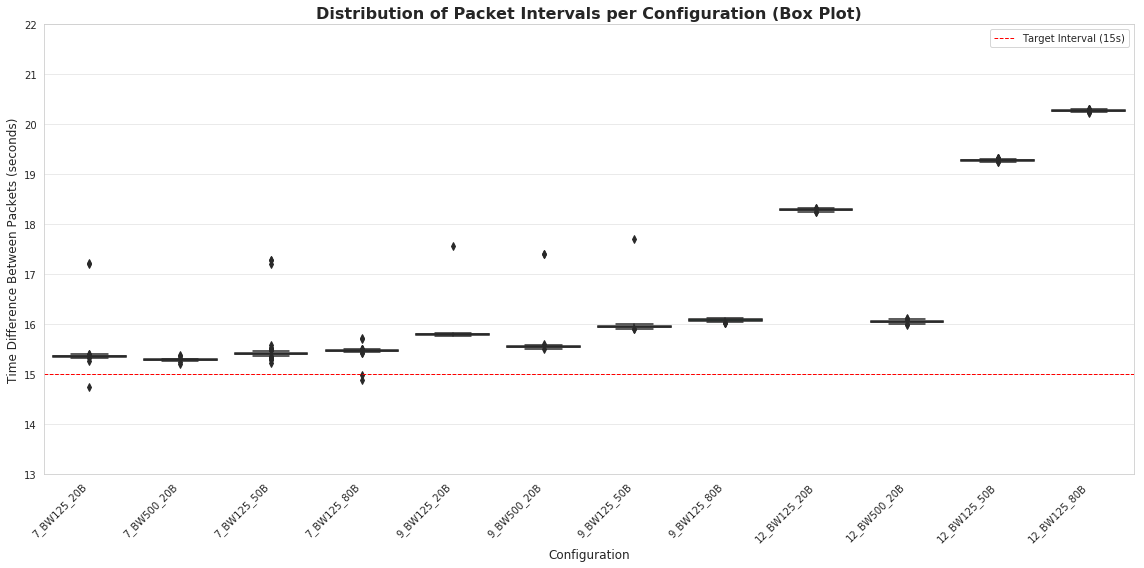


🧠 Box Plot Interpretation:
- The box represents the interquartile range (IQR), containing the middle 50% of the data.
- The line inside the box is the median packet interval.
- The 'whiskers' extend to show the range of the data, excluding outliers.
- Points beyond the whiskers are considered outliers.
- Compare the boxes and medians for each configuration to see which ones have longer/shorter typical intervals and more variability (wider boxes and longer whiskers).
- Compare the boxes/medians to the red dashed line (Target Interval) to see how configurations perform relative to expectation.


In [25]:
# ===========================
# 9b. Alternative Packet Interval Visualization (Box Plot)
# ===========================

# Use a box plot to visualize the distribution of packet intervals for each configuration
plt.figure(figsize=(16, 8))
sns.boxplot(data=df_intervals, x='config', y='time_diff_seconds_within_config', palette='viridis')

plt.axhline(TARGET_INTERVAL_SECONDS, color='red', linestyle='dashed', linewidth=1, label=f'Target Interval ({TARGET_INTERVAL_SECONDS}s)')

plt.title('Distribution of Packet Intervals per Configuration (Box Plot)', fontsize=16, fontweight='bold')
plt.xlabel('Configuration', fontsize=12)
plt.ylabel('Time Difference Between Packets (seconds)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.ylim(13, 22) # Restrict y-axis to 13s-22s
plt.tight_layout()
plt.show()

print("\n🧠 Box Plot Interpretation:")
print("- The box represents the interquartile range (IQR), containing the middle 50% of the data.")
print("- The line inside the box is the median packet interval.")
print("- The 'whiskers' extend to show the range of the data, excluding outliers.")
print("- Points beyond the whiskers are considered outliers.")
print("- Compare the boxes and medians for each configuration to see which ones have longer/shorter typical intervals and more variability (wider boxes and longer whiskers).")
print("- Compare the boxes/medians to the red dashed line (Target Interval) to see how configurations perform relative to expectation.")

# 9d. Cumulative Packet Interval Histogram

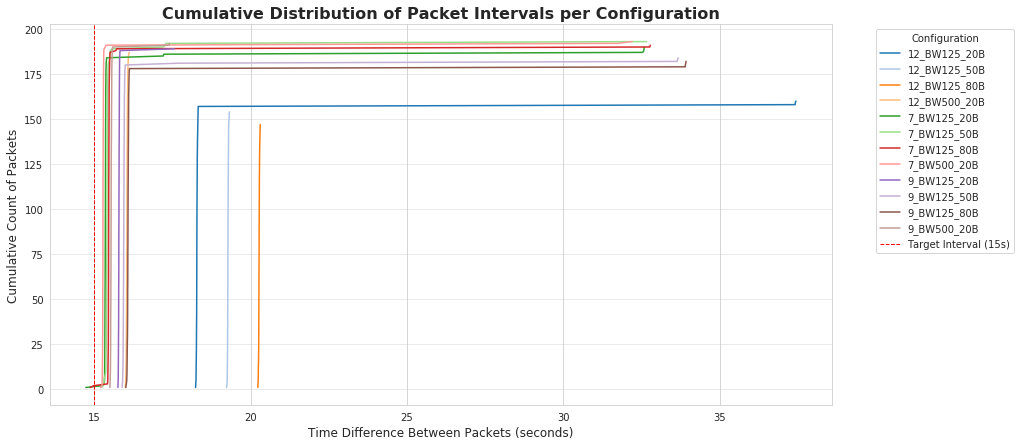

In [26]:
# ===========================
# 9d. Cumulative Packet Interval Histogram
# ===========================

# Ensure the 'time_diff_seconds_within_config' column is calculated if not already
if 'time_diff_seconds_within_config' not in df.columns:
    print("Calculating packet intervals within configurations...")
    df['time_diff_seconds_within_config'] = df.groupby('config')['timestamp'].diff().dt.total_seconds()
    df['time_diff_seconds_within_config'] = df['time_diff_seconds_within_config'].fillna(0)

# Filter out the first entry of each group as it's the start of a new sequence
df_intervals_for_hist = df[df['time_diff_seconds_within_config'] > 0].copy()

plt.figure(figsize=(14, 7))

# Iterate through each unique configuration and plot its cumulative distribution
unique_configs = sorted(df_intervals_for_hist['config'].unique())
colors = plt.cm.tab20.colors # Use a color map with enough distinct colors

for i, config in enumerate(unique_configs):
    config_data = df_intervals_for_hist[df_intervals_for_hist['config'] == config]['time_diff_seconds_within_config'].sort_values()
    cumulative_counts = np.arange(1, len(config_data) + 1)
    plt.plot(config_data, cumulative_counts, label=config, color=colors[i % len(colors)]) # Use modulo for color cycling

plt.axvline(TARGET_INTERVAL_SECONDS, color='red', linestyle='dashed', linewidth=1, label=f'Target Interval ({TARGET_INTERVAL_SECONDS}s)')

plt.title('Cumulative Distribution of Packet Intervals per Configuration', fontsize=16, fontweight='bold')
plt.xlabel('Time Difference Between Packets (seconds)', fontsize=12)
plt.ylabel('Cumulative Count of Packets', fontsize=12)
plt.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left') # Add legend outside the plot
plt.grid(axis='y', alpha=0.5)
#plt.xlim(12, 24) # Restrict x-axis to 12s-24s
#plt.tight_layout() # Adjust layout to make room for the legend
plt.show()

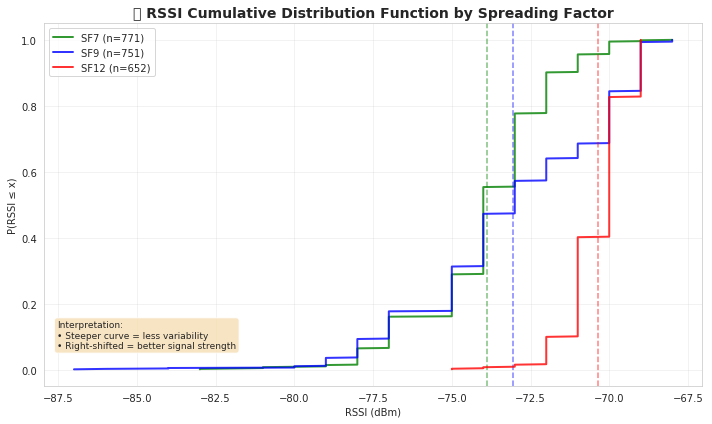

RSSI Percentiles by SF:
SF7: 10th=-77.0, 50th=-74.0, 90th=-72.0 dBm
SF9: 10th=-77.0, 50th=-73.0, 90th=-69.0 dBm
SF12: 10th=-71.0, 50th=-70.0, 90th=-69.0 dBm


In [38]:
# Cell 1: RSSI CDF by Spreading Factor
# ===========================
# CDF 1: RSSI Distribution
# ===========================
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Colors for different SF values
colors = {7: 'green', 9: 'blue', 12: 'red'}

# Plot CDF for each SF
for sf in sorted(df['sf'].unique()):
    sf_data = df[df['sf'] == sf]['rssi'].values
    
    # Sort the data
    sorted_data = np.sort(sf_data)
    
    # Calculate CDF (cumulative probabilities)
    n = len(sorted_data)
    y_values = np.arange(1, n + 1) / n
    
    # Plot CDF
    ax.plot(sorted_data, y_values, color=colors[sf], linewidth=2, 
            label=f'SF{sf} (n={n})', alpha=0.8)
    
    # Add some statistics as vertical lines
    mean_rssi = np.mean(sf_data)
    ax.axvline(mean_rssi, color=colors[sf], linestyle='--', alpha=0.5)

ax.set_title('📶 RSSI Cumulative Distribution Function by Spreading Factor', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('RSSI (dBm)')
ax.set_ylabel('P(RSSI ≤ x)')
ax.legend()
ax.grid(True, alpha=0.3)

# Add interpretation text
ax.text(0.02, 0.18, 'Interpretation:\n• Steeper curve = less variability\n• Right-shifted = better signal strength', 
        transform=ax.transAxes, verticalalignment='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Print key percentiles
print("RSSI Percentiles by SF:")
for sf in sorted(df['sf'].unique()):
    sf_rssi = df[df['sf'] == sf]['rssi']
    print(f"SF{sf}: 10th={sf_rssi.quantile(0.1):.1f}, 50th={sf_rssi.quantile(0.5):.1f}, 90th={sf_rssi.quantile(0.9):.1f} dBm")

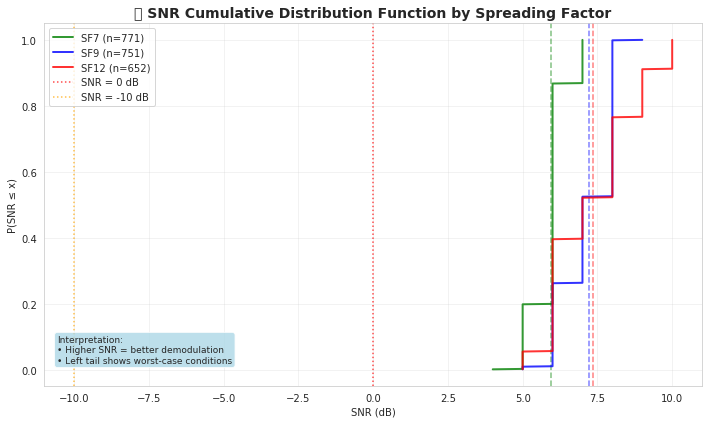

SNR Percentiles by SF:
SF7: 10th=5.0, 50th=6.0, 90th=7.0 dB
SF9: 10th=6.0, 50th=7.0, 90th=8.0 dB
SF12: 10th=6.0, 50th=7.0, 90th=9.0 dB


In [28]:
# Cell 2: SNR CDF by Spreading Factor
# ===========================
# CDF 2: SNR Distribution
# ===========================

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot CDF for each SF
for sf in sorted(df['sf'].unique()):
    sf_data = df[df['sf'] == sf]['snr'].values
    
    # Sort the data
    sorted_data = np.sort(sf_data)
    
    # Calculate CDF
    n = len(sorted_data)
    y_values = np.arange(1, n + 1) / n
    
    # Plot CDF
    ax.plot(sorted_data, y_values, color=colors[sf], linewidth=2, 
            label=f'SF{sf} (n={n})', alpha=0.8)
    
    # Add mean as vertical line
    mean_snr = np.mean(sf_data)
    ax.axvline(mean_snr, color=colors[sf], linestyle='--', alpha=0.5)

# Add reference lines for SNR thresholds
ax.axvline(0, color='red', linestyle=':', alpha=0.7, label='SNR = 0 dB')
ax.axvline(-10, color='orange', linestyle=':', alpha=0.7, label='SNR = -10 dB')

ax.set_title('📊 SNR Cumulative Distribution Function by Spreading Factor', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('P(SNR ≤ x)')
ax.legend()
ax.grid(True, alpha=0.3)

# Add interpretation
ax.text(0.02, 0.14, 'Interpretation:\n• Higher SNR = better demodulation\n• Left tail shows worst-case conditions', 
        transform=ax.transAxes, verticalalignment='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# Print SNR percentiles
print("SNR Percentiles by SF:")
for sf in sorted(df['sf'].unique()):
    sf_snr = df[df['sf'] == sf]['snr']
    print(f"SF{sf}: 10th={sf_snr.quantile(0.1):.1f}, 50th={sf_snr.quantile(0.5):.1f}, 90th={sf_snr.quantile(0.9):.1f} dB")


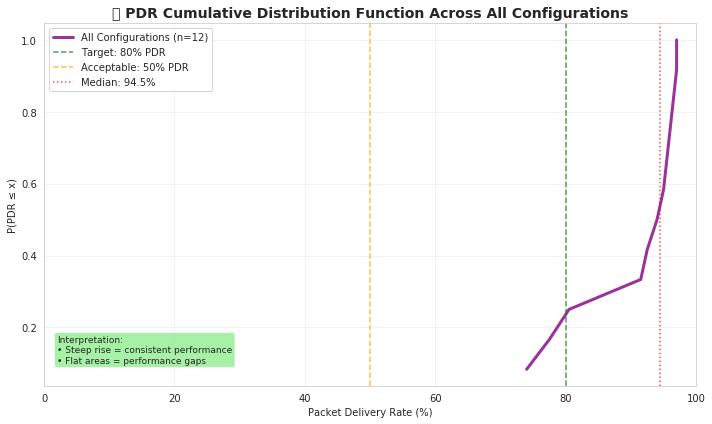

PDR Analysis:
• 0.0% of configurations have PDR ≤ 50%
• 83.3% of configurations have PDR ≥ 80%
• Median PDR: 94.5%


In [29]:
# Cell 3: PDR CDF by Configuration
# ===========================
# CDF 3: PDR Distribution 
# ===========================

# First calculate PDR using your existing function (assuming pdr_stats exists)
# If pdr_stats doesn't exist, uncomment and run your PDR calculation

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot CDF for PDR values
pdr_values = pdr_stats['pdr_percent'].values
sorted_pdr = np.sort(pdr_values)
n = len(sorted_pdr)
y_values = np.arange(1, n + 1) / n

ax.plot(sorted_pdr, y_values, color='purple', linewidth=3, 
        label=f'All Configurations (n={n})', alpha=0.8)

# Add reference lines for performance thresholds
ax.axvline(80, color='green', linestyle='--', alpha=0.7, label='Target: 80% PDR')
ax.axvline(50, color='orange', linestyle='--', alpha=0.7, label='Acceptable: 50% PDR')
ax.axvline(np.median(pdr_values), color='red', linestyle=':', alpha=0.7, label=f'Median: {np.median(pdr_values):.1f}%')

ax.set_title('📈 PDR Cumulative Distribution Function Across All Configurations', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Packet Delivery Rate (%)')
ax.set_ylabel('P(PDR ≤ x)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)

# Add interpretation
ax.text(0.02, 0.14, 'Interpretation:\n• Steep rise = consistent performance\n• Flat areas = performance gaps', 
        transform=ax.transAxes, verticalalignment='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

# Print PDR statistics
pdr_below_50 = (pdr_values <= 50).mean() * 100
pdr_above_80 = (pdr_values >= 80).mean() * 100
print(f"PDR Analysis:")
print(f"• {pdr_below_50:.1f}% of configurations have PDR ≤ 50%")
print(f"• {pdr_above_80:.1f}% of configurations have PDR ≥ 80%")
print(f"• Median PDR: {np.median(pdr_values):.1f}%")

#=============================================================================



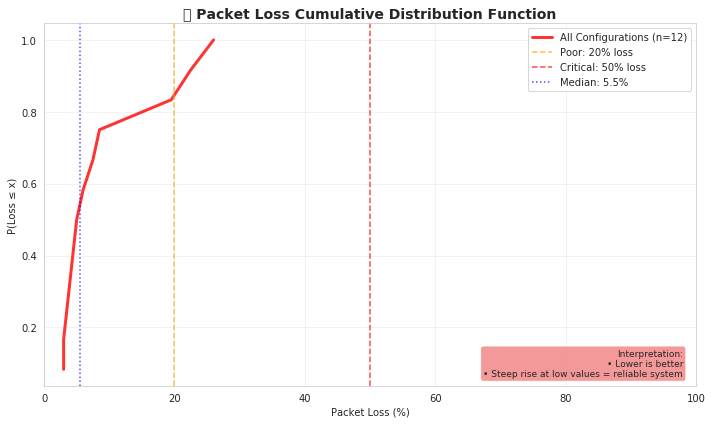

Packet Loss Analysis:
• 16.7% of configurations have loss ≥ 20%
• 0.0% of configurations have loss ≥ 50%
• Median loss: 5.5%


In [30]:
# Cell 4: Packet Loss CDF by Configuration  
# ===========================
# CDF 4: Packet Loss Distribution
# ===========================

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Calculate packet loss from PDR
packet_loss_values = 100 - pdr_stats['pdr_percent'].values
sorted_loss = np.sort(packet_loss_values)
n = len(sorted_loss)
y_values = np.arange(1, n + 1) / n

ax.plot(sorted_loss, y_values, color='red', linewidth=3, 
        label=f'All Configurations (n={n})', alpha=0.8)

# Add reference lines for loss thresholds
ax.axvline(20, color='orange', linestyle='--', alpha=0.7, label='Poor: 20% loss')
ax.axvline(50, color='red', linestyle='--', alpha=0.7, label='Critical: 50% loss')
ax.axvline(np.median(packet_loss_values), color='blue', linestyle=':', alpha=0.7, 
           label=f'Median: {np.median(packet_loss_values):.1f}%')

ax.set_title('📉 Packet Loss Cumulative Distribution Function', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Packet Loss (%)')
ax.set_ylabel('P(Loss ≤ x)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)

# Add interpretation
ax.text(0.98, 0.02, 'Interpretation:\n• Lower is better\n• Steep rise at low values = reliable system', 
        transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='right', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

plt.tight_layout()
plt.show()

# Print loss statistics
loss_above_20 = (packet_loss_values >= 20).mean() * 100
loss_above_50 = (packet_loss_values >= 50).mean() * 100
print(f"Packet Loss Analysis:")
print(f"• {loss_above_20:.1f}% of configurations have loss ≥ 20%")
print(f"• {loss_above_50:.1f}% of configurations have loss ≥ 50%")
print(f"• Median loss: {np.median(packet_loss_values):.1f}%")


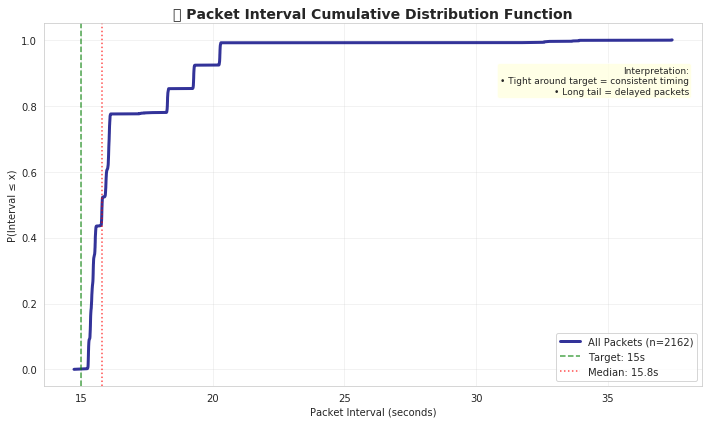

Packet Interval Analysis:
• 77.5% of packets arrived within ±2s of target (15s)
• Median interval: 15.8s
• 90th percentile: 19.3s


In [39]:
# Cell 5: Packet Interval CDF by Configuration
# ===========================
# CDF 5: Packet Interval Distribution
# ===========================

# Calculate packet intervals (assuming you have the time difference calculation)
# This assumes you've calculated packet intervals as shown in your earlier code
df_sorted = df.sort_values(['config', 'timestamp'])
df_sorted['time_diff_seconds'] = df_sorted.groupby('config')['timestamp'].diff().dt.total_seconds()

# Remove NaN values and outliers
intervals = df_sorted['time_diff_seconds'].dropna()
intervals = intervals[(intervals > 0) & (intervals < 60)]  # Remove outliers > 60 seconds

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot overall interval CDF
sorted_intervals = np.sort(intervals.values)
n = len(sorted_intervals)
y_values = np.arange(1, n + 1) / n

ax.plot(sorted_intervals, y_values, color='navy', linewidth=3, 
        label=f'All Packets (n={n})', alpha=0.8)

# Add reference lines
target_interval = 15  # Your target interval
ax.axvline(target_interval, color='green', linestyle='--', alpha=0.7, 
           label=f'Target: {target_interval}s')
ax.axvline(np.median(intervals), color='red', linestyle=':', alpha=0.7, 
           label=f'Median: {np.median(intervals):.1f}s')

ax.set_title('⏱️ Packet Interval Cumulative Distribution Function', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Packet Interval (seconds)')
ax.set_ylabel('P(Interval ≤ x)')
ax.legend()
ax.grid(True, alpha=0.3)

# Add interpretation
ax.text(0.98, 0.80, 'Interpretation:\n• Tight around target = consistent timing\n• Long tail = delayed packets', 
        transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='right', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# Print interval statistics
intervals_on_time = ((intervals >= target_interval - 2) & (intervals <= target_interval + 2)).mean() * 100
print(f"Packet Interval Analysis:")
print(f"• {intervals_on_time:.1f}% of packets arrived within ±2s of target ({target_interval}s)")
print(f"• Median interval: {np.median(intervals):.1f}s")
print(f"• 90th percentile: {np.quantile(intervals, 0.9):.1f}s")



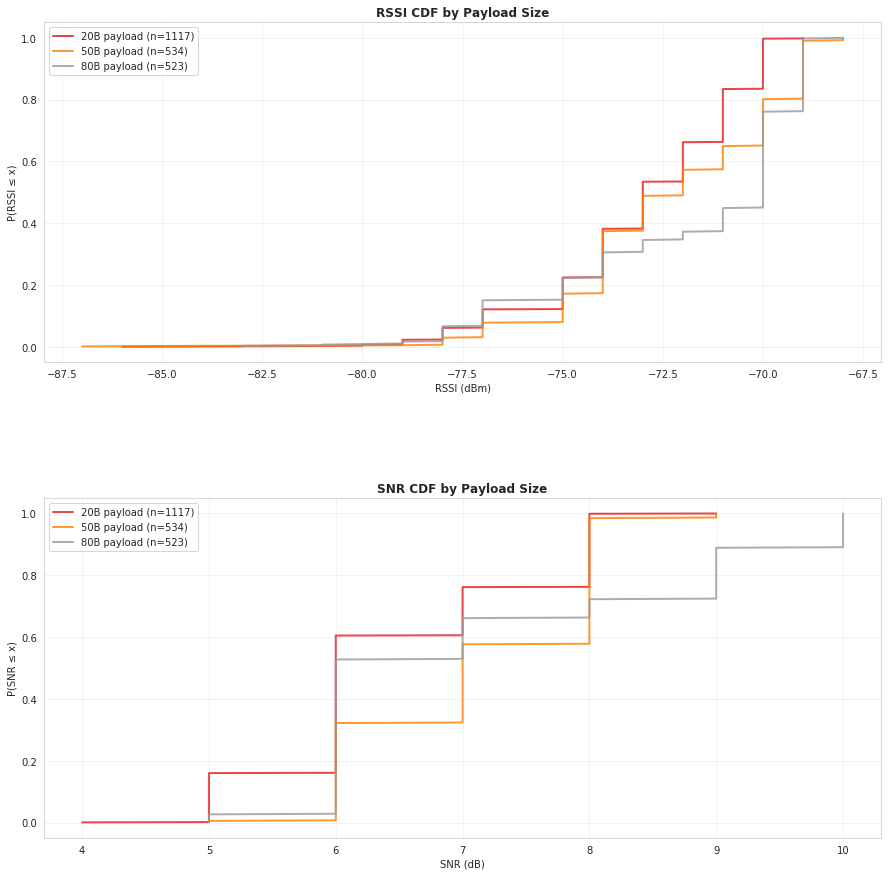

Combined Analysis: Signal quality distributions show how payload size affects link performance


In [32]:
# Cell 6: Combined Signal Quality CDF (RSSI + SNR)
# ===========================
# CDF 6: Combined Signal Quality Analysis
# ===========================

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

# RSSI CDF by payload size (if available)
if 'payload_size' in df.columns:
    payload_sizes = sorted(df['payload_size'].unique())
    payload_colors = plt.cm.Set1(np.linspace(0, 1, len(payload_sizes)))
    
    for i, payload in enumerate(payload_sizes):
        payload_data = df[df['payload_size'] == payload]['rssi'].values
        sorted_data = np.sort(payload_data)
        n = len(sorted_data)
        y_values = np.arange(1, n + 1) / n
        
        ax1.plot(sorted_data, y_values, color=payload_colors[i], linewidth=2, 
                label=f'{payload}B payload (n={n})', alpha=0.8)
else:
    # Fallback: extract from config if payload_size column doesn't exist
    payload_configs = df['config'].str.extract(r'(\d+)B').astype(int).iloc[:, 0].unique()
    payload_colors = plt.cm.Set1(np.linspace(0, 1, len(payload_configs)))
    
    for i, payload in enumerate(sorted(payload_configs)):
        payload_data = df[df['config'].str.contains(f'{payload}B')]['rssi'].values
        sorted_data = np.sort(payload_data)
        n = len(sorted_data)
        y_values = np.arange(1, n + 1) / n
        
        ax1.plot(sorted_data, y_values, color=payload_colors[i], linewidth=2, 
                label=f'{payload}B payload (n={n})', alpha=0.8)

ax1.set_title('RSSI CDF by Payload Size', fontsize=12, fontweight='bold')
ax1.set_xlabel('RSSI (dBm)')
ax1.set_ylabel('P(RSSI ≤ x)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# SNR CDF by payload size
if 'payload_size' in df.columns:
    for i, payload in enumerate(payload_sizes):
        payload_data = df[df['payload_size'] == payload]['snr'].values
        sorted_data = np.sort(payload_data)
        n = len(sorted_data)
        y_values = np.arange(1, n + 1) / n
        
        ax2.plot(sorted_data, y_values, color=payload_colors[i], linewidth=2, 
                label=f'{payload}B payload (n={n})', alpha=0.8)
else:
    for i, payload in enumerate(sorted(payload_configs)):
        payload_data = df[df['config'].str.contains(f'{payload}B')]['snr'].values
        sorted_data = np.sort(payload_data)
        n = len(sorted_data)
        y_values = np.arange(1, n + 1) / n
        
        ax2.plot(sorted_data, y_values, color=payload_colors[i], linewidth=2, 
                label=f'{payload}B payload (n={n})', alpha=0.8)

ax2.set_title('SNR CDF by Payload Size', fontsize=12, fontweight='bold')
ax2.set_xlabel('SNR (dB)')
ax2.set_ylabel('P(SNR ≤ x)')
ax2.legend()
ax2.grid(True, alpha=0.3)

#plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

print("Combined Analysis: Signal quality distributions show how payload size affects link performance")

# Temperature Over Time

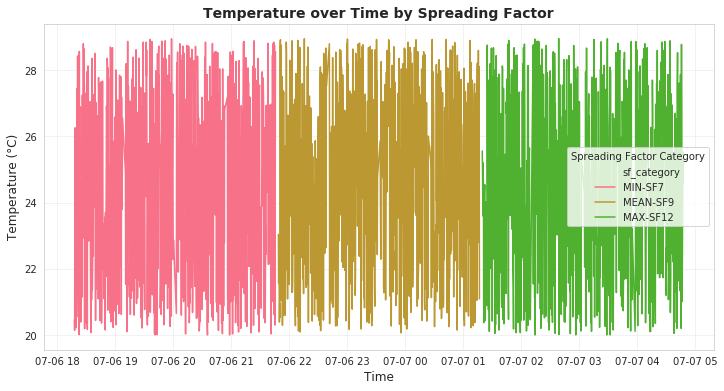

In [33]:
# ===========================
# PLOT 7: TEMPERATURE OVER TIME
# ===========================

import json

# Extract temperature from the 'data' column
def extract_temperature(data_string):
    try:
        data_dict = json.loads(data_string)
        return data_dict.get("TC") # Assuming 'TC' is the temperature key
    except:
        return None # Return None if parsing fails

df['temperature'] = df['data'].apply(extract_temperature)

# Plot temperature over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='timestamp', y='temperature', hue='sf_category')
plt.title('Temperature over Time by Spreading Factor', fontsize=14, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Spreading Factor Category') # Added legend title
plt.show()

# Metrics against Time


📊 Plotting data for BW125...


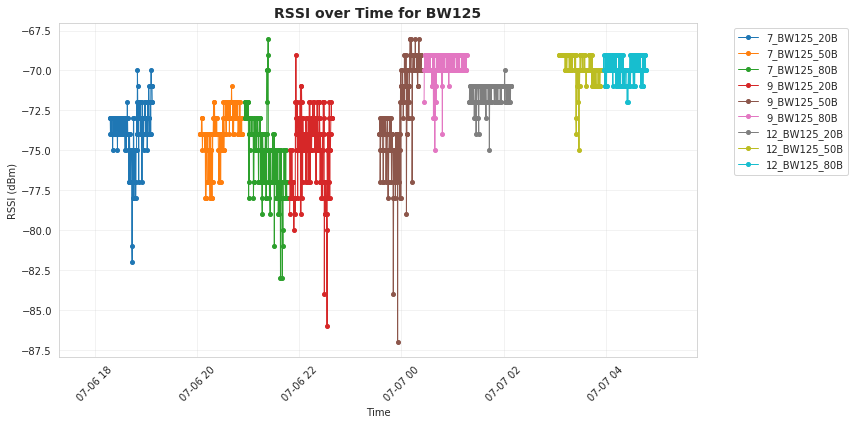

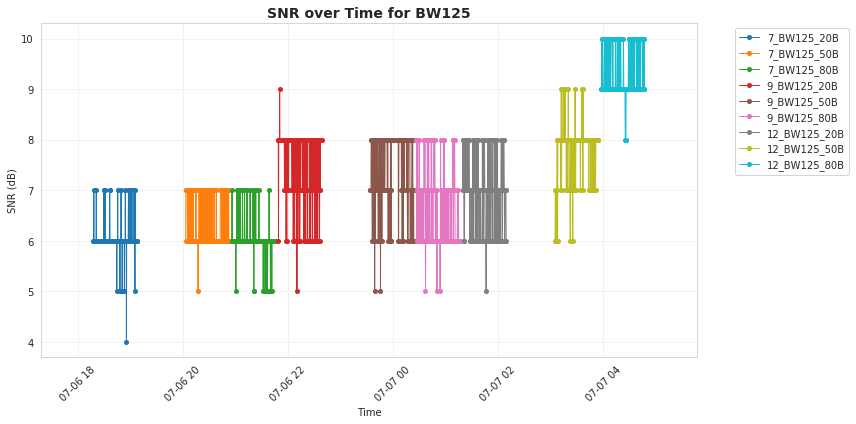

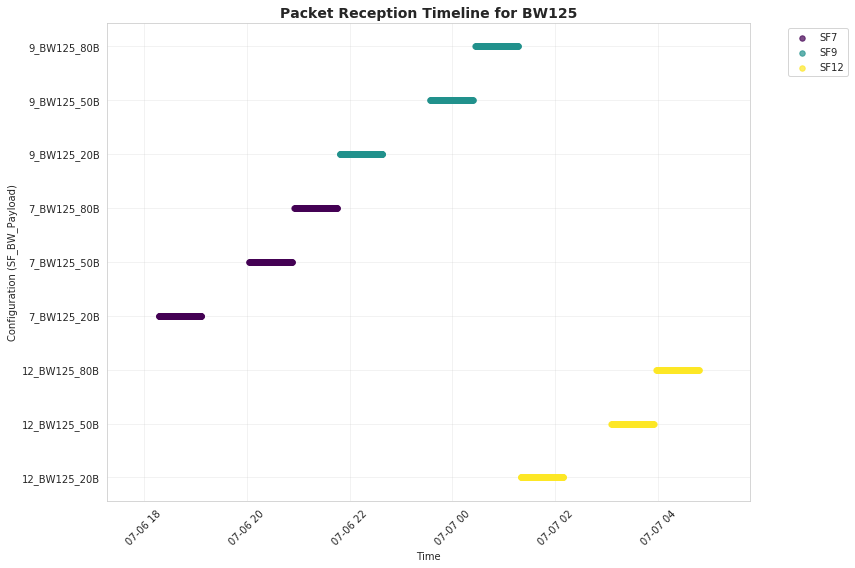


📊 Plotting data for BW500...


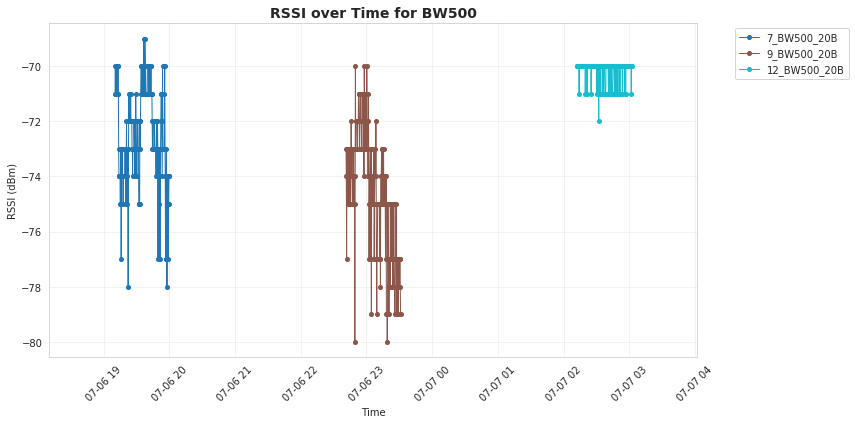

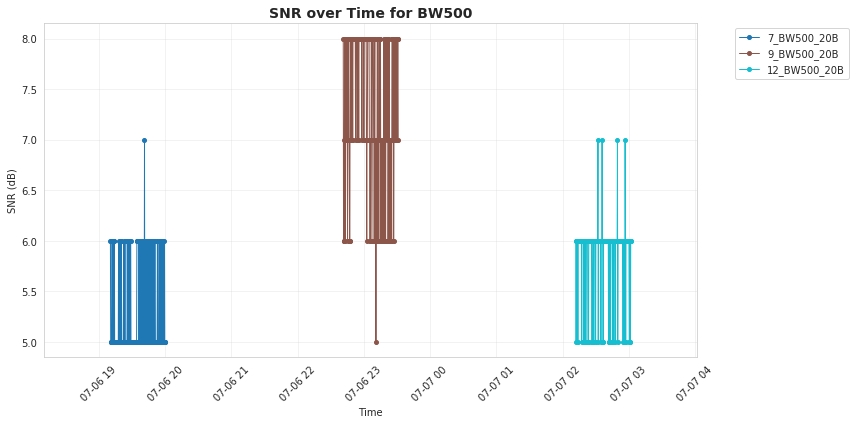

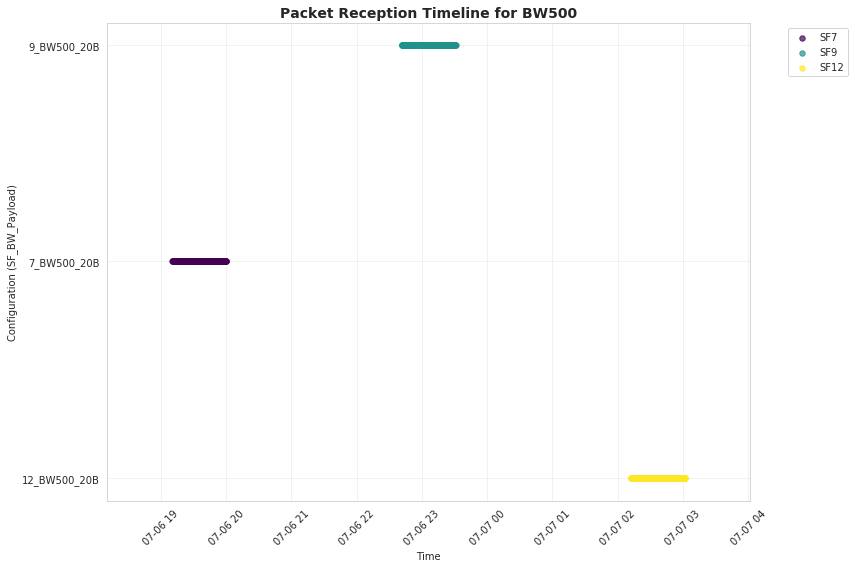

In [34]:
# Direct conversion of the original plotly code to matplotlib
def plot_bw_specific_data(df, bw_value):
    """
    Plots RSSI, SNR, and Packet delivery rate over time for a specific BW using matplotlib.
    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        bw_value (int): The BW value to filter the data (e.g., 125 or 500).
    """
    print(f"\n📊 Plotting data for BW{bw_value}...")
    
    # Filter data for the specific BW
    df_bw = df[df['bw'] == bw_value].copy()
    if df_bw.empty:
        print(f"❌ No data found for BW{bw_value}.")
        return
    
    # Ensure timestamp is sorted for time series plots
    df_bw = df_bw.sort_values('timestamp')
    
    # Calculate time range with 1-hour margins
    time_min_data = df_bw['timestamp'].min()
    time_max_data = df_bw['timestamp'].max()
    time_min = time_min_data - pd.Timedelta(hours=1)
    time_max = time_max_data + pd.Timedelta(hours=1)
    
    # Get unique configurations and colors
    configs = df_bw['config'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(configs)))
    color_map = {config: colors[i] for i, config in enumerate(configs)}
    
    # Plotting RSSI over time
    plt.figure(figsize=(12, 6))
    for config in configs:
        config_data = df_bw[df_bw['config'] == config]
        plt.plot(config_data['timestamp'], config_data['rssi'], 
                'o-', color=color_map[config], label=config, markersize=4, linewidth=1)
    
    plt.title(f'RSSI over Time for BW{bw_value}', fontsize=14, fontweight='bold')
    plt.xlabel('Time')
    plt.ylabel('RSSI (dBm)')
    plt.xlim(time_min, time_max)  # Restrict x-axis
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plotting SNR over time
    plt.figure(figsize=(12, 6))
    for config in configs:
        config_data = df_bw[df_bw['config'] == config]
        plt.plot(config_data['timestamp'], config_data['snr'], 
                'o-', color=color_map[config], label=config, markersize=4, linewidth=1)
    
    plt.title(f'SNR over Time for BW{bw_value}', fontsize=14, fontweight='bold')
    plt.xlabel('Time')
    plt.ylabel('SNR (dB)')
    plt.xlim(time_min, time_max)  # Restrict x-axis
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plotting Packet Reception Timeline
    plt.figure(figsize=(12, 8))
    
    # Get unique configs and SF values
    configs_ordered = sorted(df_bw['config'].unique())
    sf_values = sorted(df_bw['sf'].unique())
    sf_colors = plt.cm.viridis(np.linspace(0, 1, len(sf_values)))
    sf_color_map = {sf: sf_colors[i] for i, sf in enumerate(sf_values)}
    
    # Create y-axis mapping
    y_positions = {config: i for i, config in enumerate(configs_ordered)}
    
    # Plot points for each SF
    for sf in sf_values:
        sf_data = df_bw[df_bw['sf'] == sf]
        x_vals = sf_data['timestamp'].values
        y_vals = [y_positions[config] for config in sf_data['config'].values]
        
        plt.scatter(x_vals, y_vals, color=sf_color_map[sf], 
                   alpha=0.7, s=30, label=f'SF{sf}')
    
    plt.title(f'Packet Reception Timeline for BW{bw_value}', fontsize=14, fontweight='bold')
    plt.xlabel('Time')
    plt.ylabel('Configuration (SF_BW_Payload)')
    plt.xlim(time_min, time_max)  # Restrict x-axis to data range + 1 hour margins
    plt.yticks(range(len(configs_ordered)), configs_ordered)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for BW125
plot_bw_specific_data(df, 125)
# Plot for BW500
plot_bw_specific_data(df, 500)

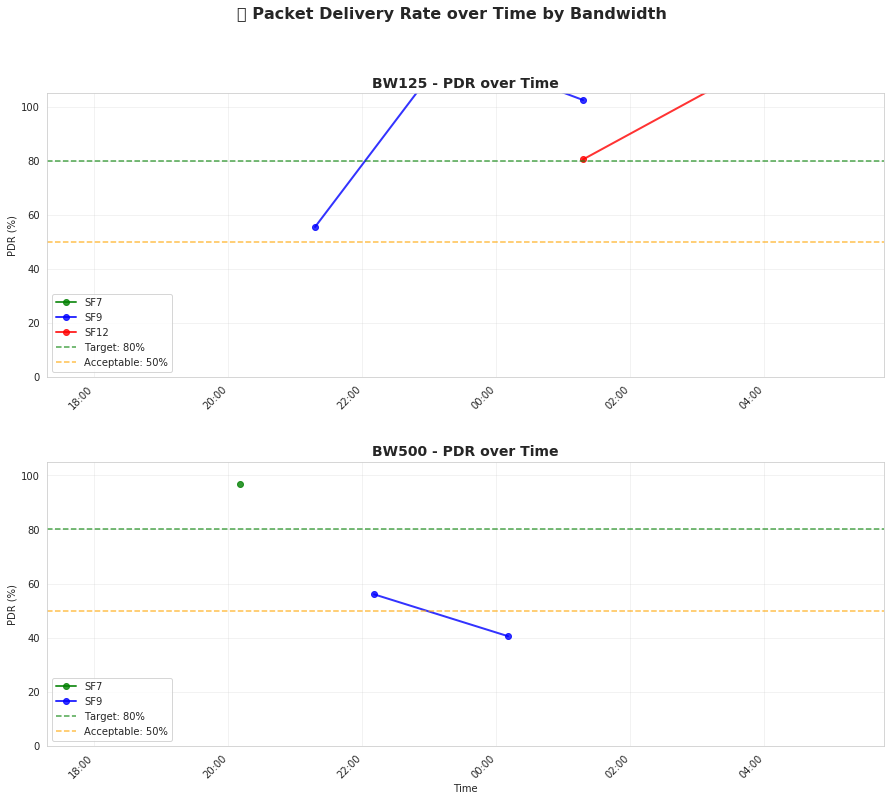


📈 PDR Over Time Summary:
BW125 - Average PDR by SF:
  SF7: 144.2%
  SF9: 93.0%
  SF12: 94.0%
BW500 - Average PDR by SF:
  SF7: 97.0%
  SF9: 48.2%


In [35]:
# ===========================
# PDR OVER TIME BY BANDWIDTH
# ===========================

def calculate_rolling_pdr(df, time_window_hours=2):
    """
    Calculate PDR over rolling time windows
    """
    # Sort by timestamp
    df_sorted = df.sort_values('timestamp')
    
    # Create time bins
    time_min = df_sorted['timestamp'].min()
    time_max = df_sorted['timestamp'].max()
    time_range = pd.date_range(start=time_min, end=time_max, freq=f'{time_window_hours}H')
    
    pdr_results = []
    
    for i in range(len(time_range) - 1):
        window_start = time_range[i]
        window_end = time_range[i + 1]
        window_center = window_start + (window_end - window_start) / 2
        
        # Filter data for this time window
        window_data = df_sorted[
            (df_sorted['timestamp'] >= window_start) & 
            (df_sorted['timestamp'] < window_end)
        ]
        
        if len(window_data) > 0:
            # Calculate PDR for each SF in this window
            for sf in window_data['sf'].unique():
                sf_data = window_data[window_data['sf'] == sf]
                packets_received = len(sf_data)
                expected_packets = 200  # Your expected packets per config
                pdr = (packets_received / expected_packets * 100)
                
                pdr_results.append({
                    'timestamp': window_center,
                    'sf': sf,
                    'packets_received': packets_received,
                    'pdr_percent': pdr
                })
    
    return pd.DataFrame(pdr_results)

# Calculate PDR over time for each BW
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
fig.suptitle('📊 Packet Delivery Rate over Time by Bandwidth', fontsize=16, fontweight='bold')

# Set time limits with 1-hour margins
data_time_min = df['timestamp'].min()
data_time_max = df['timestamp'].max()
time_min = data_time_min - pd.Timedelta(hours=1)
time_max = data_time_max + pd.Timedelta(hours=1)

# Colors for different SF
colors = {7: 'green', 9: 'blue', 12: 'red'}

# Extract BW values from config or use your method
# Assuming BW is in the config string like "SF7_BW125_20B"
df['bw_extracted'] = df['config'].str.extract(r'BW(\d+)').astype(int)

# Plot 1: BW125
ax1.set_title('BW125 - PDR over Time', fontsize=14, fontweight='bold')
bw_125_data = df[df['bw_extracted'] == 125]

if not bw_125_data.empty:
    pdr_125 = calculate_rolling_pdr(bw_125_data, time_window_hours=2)
    
    for sf in sorted(pdr_125['sf'].unique()):
        sf_pdr = pdr_125[pdr_125['sf'] == sf]
        ax1.plot(sf_pdr['timestamp'], sf_pdr['pdr_percent'], 
                'o-', color=colors[sf], label=f'SF{sf}', 
                markersize=6, linewidth=2, alpha=0.8)

ax1.set_ylabel('PDR (%)')
ax1.set_xlim(time_min, time_max)
ax1.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Target: 80%')
ax1.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='Acceptable: 50%')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 105)

# Plot 2: BW500
ax2.set_title('BW500 - PDR over Time', fontsize=14, fontweight='bold')
bw_500_data = df[df['bw_extracted'] == 500]

if not bw_500_data.empty:
    pdr_500 = calculate_rolling_pdr(bw_500_data, time_window_hours=2)
    
    for sf in sorted(pdr_500['sf'].unique()):
        sf_pdr = pdr_500[pdr_500['sf'] == sf]
        ax2.plot(sf_pdr['timestamp'], sf_pdr['pdr_percent'], 
                'o-', color=colors[sf], label=f'SF{sf}', 
                markersize=6, linewidth=2, alpha=0.8)

ax2.set_xlabel('Time')
ax2.set_ylabel('PDR (%)')
ax2.set_xlim(time_min, time_max)
ax2.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Target: 80%')
ax2.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='Acceptable: 50%')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 105)

# Format x-axis
from matplotlib.dates import DateFormatter, HourLocator
for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(HourLocator(interval=2))
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.subplots_adjust(hspace=0.3)
# plt.tight_layout()
plt.show()

# Print summary
print("\n📈 PDR Over Time Summary:")
if not bw_125_data.empty:
    print(f"BW125 - Average PDR by SF:")
    pdr_125_summary = pdr_125.groupby('sf')['pdr_percent'].mean()
    for sf, avg_pdr in pdr_125_summary.items():
        print(f"  SF{sf}: {avg_pdr:.1f}%")

if not bw_500_data.empty:
    print(f"BW500 - Average PDR by SF:")
    pdr_500_summary = pdr_500.groupby('sf')['pdr_percent'].mean()
    for sf, avg_pdr in pdr_500_summary.items():
        print(f"  SF{sf}: {avg_pdr:.1f}%")